<a href="https://colab.research.google.com/github/d4vidi4n/EL4106/blob/main/ANN_Proy_IC_JE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preámbulo

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

!pip install pytorch-ignite
!pip install early-stopping-pytorch
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
from ignite.metrics import Loss
from early_stopping_pytorch import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from statsmodels.tsa.ar_model import AutoReg
import scipy.stats as sp
import gc
import torch.nn.functional as F
from sklearn import svm
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 754.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

# Lectura de datos

In [2]:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea3_train.txt
!ls

Saving df_test_no_labels.csv to df_test_no_labels.csv
Saving df_trainval.csv to df_trainval.csv
df_test_no_labels.csv  df_trainval.csv	sample_data


In [3]:
df_trainval = pd.read_csv('df_trainval.csv')
df_test_no_labels = pd.read_csv('df_test_no_labels.csv')
df_trainval
# df_test_no_labels

R1_0      R1_1      R1_2      R1_3      R1_4      R1_5      R1_6  \
0     12.73430  12.73430  12.73420  12.73420  12.73550  12.73560  12.73700   
1     11.51190  11.52490  11.53670  11.54820  11.55860  11.56800  11.57650   
2     10.85570  10.85860  10.86130  10.86350  10.86440  10.86490  10.86450   
3     12.55170  12.55180  12.55190  12.55190  12.55200  12.55200  12.55210   
4      8.78442   8.77909   8.77488   8.77016   8.76573   8.76157   8.75735   
...        ...       ...       ...       ...       ...       ...       ...   
8791  12.39290  12.39290  12.39260  12.39240  12.39260  12.39240  12.39240   
8792  12.83420  12.83410  12.83410  12.83410  12.83410  12.83410  12.83410   
8793  11.99420  11.99420  11.99400  11.99400  11.99380  11.99390  11.99390   
8794  12.94500  12.94540  12.94560  12.94460  12.94370  12.94260  12.94080   
8795  12.22490  12.22540  12.22590  12.22630  12.22670  12.22680  12.22710   

          R1_7      R1_8      R1_9  ...  Humidity_119  Humidity_120  \
0     12.73740  12.73710  12.73700  ...       60.0959       60.1002   
1     11.58420  11.59120  11.59770  ...       64.9539       64.9585   
2     10.86390  10.86280  10.86110  ...       56.4906       56.4957   
3     12.55210  12.55220  12.55220  ...       64.5927       64.5912   
4      8.75307   8.74919   8.74538  ...       58.2097       58.2229   
...        ...       ...       ...  ...           ...           ...   
8791  12.39290  12.39280  12.39260  ...       49.8931       49.8782   
8792  12.83410  12.83410  12.83410  ...       53.2695       53.2648   
8793  11.99350  11.99360  11.99370  ...       67.2733       67.2698   
8794  12.94000  12.93950  12.93910  ...       52.3949       52.3953   
8795  12.22740  12.22720  12.22750  ...       56.7664       56.7630   

      Humidity_121  Humidity_122  Humidity_123  Humidity_124  Humidity_125  \
0          60.1041       60.1076       60.1108       60.1137       60.1163   
1          64.9626       64.9663       64.9684       64.9687       64.9689   
2          56.5004       56.5045       56.5083       56.5118       56.5149   
3          64.5898       64.5886       64.5875       64.5865       64.5855   
4          58.2348       58.2456       58.2553       58.2642       58.2722   
...            ...           ...           ...           ...           ...   
8791       49.8613       49.8459       49.8321       49.8195       49.8082   
8792       53.2605       53.2592       53.2585       53.2578       53.2572   
8793       67.2665       67.2636       67.3011       67.3350       67.3656   
8794       52.3956       52.3960       52.3963       52.3965       52.3968   
8795       56.7600       56.7573       56.7548       56.7526       56.7506   

      Humidity_126  Humidity_127  class  
0          60.1187       60.1208      1  
1          64.9691       64.9693      1  
2          56.5151       56.5149      1  
3          64.5847       64.5839      1  
4          58.2794       58.2948      1  
...            ...           ...    ...  
8791       49.7979       49.7878      3  
8792       53.2567       53.2562      3  
8793       67.3934       67.4185      3  
8794       52.3970       52.3989      3  
8795       56.7487       56.7471      3  

[8796 rows x 1153 columns]

# Definición de las características

Vector de cálculo de características (Media, Varianza, etc) ()

In [4]:
from statsmodels.tsa.ar_model import AutoReg

def get_single_ar_coeff(signal, order=3, method='mean'):
    try:
        model = AutoReg(signal, lags=order, old_names=False)
        result = model.fit()
        coeffs = result.params[1:]  # Ignorar el intercepto
        if method == 'mean':
            return np.mean(coeffs)
        elif method == 'norm':
            return np.linalg.norm(coeffs)
        elif method == 'first':
            return coeffs[0]
        elif method == 'max_abs':
            return coeffs[np.argmax(np.abs(coeffs))]
        else:
            return np.nan
    except:
        return np.nan

In [5]:
def extract_features(signal):
  STD_THRESHOLD = 1e-12

  is_constant = np.std(signal) < STD_THRESHOLD
  # is_constant = np.std(signal) == 0
  is_too_short = len(signal) < 2

  return {
      'mean': np.mean(signal),
      'var': np.var(signal),
      'mad': np.median(np.abs(signal - np.median(signal))),
      'max': np.max(signal),
      'min': np.min(signal),
      'ran': np.max(signal) - np.min(signal),
      'sma': np.sum(np.abs(signal)),
      'enrgy': np.sum(signal**2) / len(signal),
      'iqr': sp.iqr(signal),
      'entpy': sp.entropy(signal),
      'arCoeff': get_single_ar_coeff(signal),  # Placeholder; lo puedes reemplazar cuando tengas la función
      'corr': 0.0 if is_constant or is_too_short else np.corrcoef(signal[:-1], signal[1:])[0, 1]
  }

def calculation_feature_vector(df_data):
    sensors = [f'R{j}' for j in range(1, 9)] + ['Humidity']
    feature_list = []

    # for idx, row in df_data[8215:8220].iterrows():
    # for idx, row in df_data[8216:8217].iterrows(): #Dato problemático -> df_data.iloc[8216]
    for idx, row in df_data.iterrows():
        features = {}
        for sensor in sensors:
            start_col = f'{sensor}_0'
            end_col = f'{sensor}_127'
            signal = row[start_col:end_col].to_numpy()
            feats = extract_features(signal)
            # Prefix feature names with sensor ID
            feats_prefixed = {f'{key}_{sensor}': value for key, value in feats.items()}
            features.update(feats_prefixed)
        if 'class' in df_data.columns:
            features['class'] = row['class']
        feature_list.append(features)

    df_features = pd.DataFrame(feature_list)
    return df_features

In [6]:
train_val_data = calculation_feature_vector(df_trainval)
df_test_data = calculation_feature_vector(df_test_no_labels)

In [7]:
df_train, df_val = train_test_split(train_val_data, test_size=0.3, random_state=10, stratify=train_val_data['class'])

df_train_GS, df_val_GS = train_test_split(df_val, test_size=0.3, random_state=10, stratify=df_val['class'])

df_test = df_test_data.copy()

In [8]:
# df_test = calculation_feature_vector(df_test_no_labels)
scaler = StandardScaler().fit(df_train.iloc[:,0:-1])

df_train.iloc[:,0:-1] = scaler.transform(df_train.iloc[:,0:-1])
df_val.iloc[:,0:-1] = scaler.transform(df_val.iloc[:,0:-1])
df_test.iloc[:,:] = scaler.transform(df_test_data.iloc[:,0:])

df_train_GS.iloc[:,0:-1] = scaler.transform(df_train_GS.iloc[:,0:-1])
df_val_GS.iloc[:,0:-1] = scaler.transform(df_val_GS.iloc[:,0:-1])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

df_train_GS_w_class = df_train_GS.copy()
df_val_GS_w_class = df_val_GS.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

y_train_GS = df_train_GS.pop('class')# - 1
y_val_GS = df_val_GS.pop('class')# - 1

In [9]:
df_val_w_class

mean_R1    var_R1    mad_R1    max_R1    min_R1    ran_R1    sma_R1  \
239   1.096543 -0.158607 -0.304521  1.117704  1.066853 -0.364152  1.096543   
5350  0.514111 -0.156605 -0.192896  0.500405  0.520910 -0.294782  0.514111   
7493 -2.436857 -0.158313 -0.267081 -2.696413 -2.173449 -0.340265 -2.436857   
6571  0.818759 -0.158171 -0.240735  0.818439  0.808927 -0.351063  0.818759   
6549  0.634276 -0.158563 -0.326707  0.621760  0.644714 -0.358589  0.634276   
...        ...       ...       ...       ...       ...       ...       ...   
5597 -5.223277  4.343969  1.097718 -4.741692 -5.646002  4.955066 -5.223277   
3566  0.445346 -0.157118 -0.269161  0.419248  0.452345 -0.295437  0.445346   
2263 -1.541668 -0.109294  0.395039 -1.625143 -1.442766  0.199310 -1.541668   
2105  0.005850 -0.083495  0.563515  0.068372 -0.062325  0.366189  0.005850   
3891 -0.270332 -0.158538 -0.323240 -0.354405 -0.183013 -0.357280 -0.270332   

      enrgy_R1    iqr_R1  entpy_R1  ...  max_Humidity  min_Humidity  \
239   1.194178 -0.319017  0.136616  ...     -0.173576     -0.095768   
5350  0.528180 -0.226845  0.135501  ...     -1.280577     -1.353502   
7493 -2.452145 -0.299145  0.136288  ...     -0.864471     -0.855229   
6571  0.873338 -0.278287  0.136381  ...     -0.175231     -0.107613   
6549  0.663481 -0.325923  0.136586  ...      0.660413      0.690633   
...        ...       ...       ...  ...           ...           ...   
5597 -4.644852  6.441921 -6.597329  ...     -0.555134     -0.899213   
3566  0.451239 -0.266871  0.135775  ...     -0.643925     -0.663743   
2263 -1.617419  0.290112  0.099791  ...     -0.273971     -0.209786   
2105 -0.031779  0.365795  0.092024  ...     -0.570028     -0.779728   
3891 -0.328304 -0.331843  0.136551  ...      2.017093      2.098333   

      ran_Humidity  sma_Humidity  enrgy_Humidity  iqr_Humidity  \
239      -0.712138     -0.133996       -0.171332     -0.553655   
5350      0.493322     -1.277434       -1.220930     -0.200599   
7493     -0.186394     -0.857180       -0.847699     -0.045940   
6571     -0.621816     -0.140114       -0.177233     -0.530681   
6549     -0.188785      0.672947        0.634271     -0.106809   
...            ...           ...             ...           ...   
5597      2.989597     -0.664565       -0.670685      4.095286   
3566      0.098369     -0.651800       -0.659964      0.259590   
2263     -0.603237     -0.244440       -0.277415     -0.483233   
2105      1.794070     -0.739110       -0.740035      0.156405   
3891     -0.478331      2.054826        2.138382     -0.489154   

      entpy_Humidity  arCoeff_Humidity  corr_Humidity  class  
239         0.238132          0.062845       0.346398    1.0  
5350        0.038187          0.312768      -0.353743    1.0  
7493        0.172149          0.173199       0.018813    2.0  
6571        0.235845          0.753173       0.627022    2.0  
6549        0.183043          0.178517       0.475780    2.0  
...              ...               ...            ...    ...  
5597       -3.242779          0.834277       0.699856    1.0  
3566        0.095930         -0.378238      -0.287835    3.0  
2263        0.234489          0.325770      -0.261220    2.0  
2105       -0.395514         -0.191735       0.477835    2.0  
3891        0.232015         -0.234638       0.335167    3.0  

[2639 rows x 109 columns]

## Crear datasets y dataloaders para pytorch (train)

In [10]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:108].astype(np.float32)
labels_train = df_train_w_class.to_numpy()[:,108].astype(int) - 1
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:108].astype(np.float32)
labels_val = df_val_w_class.to_numpy()[:,108].astype(int) - 1
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,:].astype(np.float32)
dataset_test = [ {"features":feats_test[i,:]} for i in range(feats_test.shape[0]) ]

Subconjutos del conjunto de validación para Grid Search


In [11]:
feats_train_GS = df_train_GS.to_numpy()[:,0:108].astype(np.float32)
labels_train_GS = df_train_GS_w_class.to_numpy()[:,108].astype(int) - 1
dataset_train_GS = [ {"features":feats_train_GS[i,:], "labels":labels_train_GS[i]} for i in range(feats_train_GS.shape[0]) ]

feats_val_GS = df_val_GS.to_numpy()[:,0:108].astype(np.float32)
labels_val_GS = df_val_GS_w_class.to_numpy()[:,108].astype(int) - 1
dataset_val_GS = [ {"features":feats_val_GS[i,:], "labels":labels_val_GS[i]} for i in range(feats_val_GS.shape[0]) ]

In [12]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

dataloader_train_GS = torch.utils.data.DataLoader(dataset_train_GS, batch_size=128, shuffle=True, num_workers=0)
dataloader_val_GS = torch.utils.data.DataLoader(dataset_val_GS, batch_size=128, shuffle=True, num_workers=0)

In [13]:
torch.cuda.empty_cache()

## Entrenamiento y validación

Se define una modificación del código base de EarlyStopping de Pytorch con el propósito de evitar que imprima cada vez que está guardando el modelo y la cuenta de cuantas épocas han pasado desde que el loss comenzó a subir de nuevo

In [14]:
# Sustituye esto:
from early_stopping_pytorch import EarlyStopping

# Por esto (versión propia):
class EarlyStoppingCustom:
    def __init__(self, patience=15, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf")

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Guarda el modelo si ha habido mejora'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'best_model.pt')
        self.val_loss_min = val_loss


Esta función se utiliza para entrenar el modelo y validarlo

In [15]:
# def train_model(model, patience, n_epochs, optimizer):
def train_model_generic(model, patience, n_epochs, optimizer, dataloader_tr, dataloader_vl):

  # Listas para guardar valores de loss por cada batch y por cada época
  train_losses = []
  valid_losses = []
  # Listas para guardar los pesos de cada batch, depende del tamaño de cada batch, esto es importante porque el último batch siempre es más pequeño
  batch_weights_train = []
  batch_weights_val = []
  # Listas para guardar la pérdida promedio de cada época
  avg_train_losses = []
  avg_valid_losses = []
  #Bandera para guardar el modelo una única vez bajo el nombre best_model.pt
  model_saved = False

  # initialize the early_stopping object
  early_stopping = EarlyStoppingCustom(patience=patience, verbose=False)

  start = time.time()
  for epoch in range(1, n_epochs + 1):

    # Entrenamiento
    model.train() # prep model for training

    for batch in dataloader_train:
      inputs = batch["features"].to(device)
      targets = batch["labels"].to(device) # Correponde a las clases de los datos

      # Igualar a 0 los gradientes de todas las variables optimizadas
      optimizer.zero_grad()
      # Predicciones
      output = model(inputs)
      # Cálculo de la pérdida
      loss = criterion(output, targets)
      # backward pass
      loss.backward()
      # Actualización de parámetros de la red (mediante Adam)
      optimizer.step()
      train_losses.append(loss.item())
      batch_weights_train.append(targets.size(0))

    # Validación
    model.eval()
    with torch.no_grad():
      for batch in dataloader_val:
        inputs = batch["features"].to(device)
        targets = batch["labels"].to(device)

        # Predicciones
        output = model(inputs)
        # Cálculo de la pérdida
        loss = criterion(output, targets)
        # Loss de validación de un solo batch
        valid_losses.append(loss.item())
        batch_weights_val.append(targets.size(0))


    train_loss = np.average(np.array(train_losses), weights = np.array(batch_weights_train))
    valid_loss = np.average(np.array(valid_losses), weights = np.array(batch_weights_val))

    # Se calcula el promedio del loss de todas las épocas
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(n_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' + f'train_loss: {train_loss:.6f} ' + f'valid_loss: {valid_loss:.6f}')
    # print(print_msg)

    # Se reinician las listas para guardar los valores de loss y los pesos de cada batch de la siguiente época
    train_losses = []
    valid_losses = []
    batch_weights_train = []
    batch_weights_val = []

    early_stopping(valid_loss, model)

    if early_stopping.early_stop and not model_saved:
        best_epoch = epoch - patience
        val_loss_min = avg_valid_losses[best_epoch - 1]
        print('Early stopping at -------------------------------------------------->',best_epoch)
        torch.save(model.state_dict(), 'best_model.pt') # En la línea a continuación se guarda el último checkpoint guardado por earlystopping, despues no se vuelve a guardar bajo este mismo nombre, de manera que este es el mejor modelo basado en patience early stopping
        model_saved = True
        training_time = time.time() - start # Se calcula aqui porque el modelo puede terminar de entrenarse antes de las 1000 épocas, por lo tanto, no sería correcto calcularlo al final, ya que el loss de validación y entrenamiento que se sigue calculando es para ver que tanto diverge el de validación en comparación al de entrenamiento para la totalidad de las épocas

  # Cargar el mejor modelo guardado con el criterio de patience early stopping
  model.load_state_dict(torch.load('best_model.pt', weights_only=True))
  print(f"Mejor modelo en la época {best_epoch} con loss de validación = {val_loss_min:.6f}")

  return  model, avg_train_losses, avg_valid_losses, training_time, best_epoch, dataloader_tr, dataloader_vl

## Gráficos de resultados

In [16]:
def results_ANN(model, train_loss_values, valid_loss_values, t_time, best_ep, dataloader_tr, dataloader_vl):
    os.makedirs(ruta, exist_ok=True)

    # Obtener el nombre del modelo
    nombre_red = model.name  # Devuelve: 'MiRed'
    epochs = np.linspace(1, len(train_loss_values), len(train_loss_values))
    loss_valid_best_epoch = valid_loss_values[best_ep - 1]
    loss_train_best_epoch = train_loss_values[best_ep - 1]

    # Gráfico de loss de validación y entrenamiento
    prop = 0.95
    figsize = (prop*6.4, 0.95*4.8)
    plt.figure(figsize = figsize)
    plt.plot(epochs, train_loss_values, lw=1, color='blue', label='Train')
    plt.plot(epochs, valid_loss_values, lw=1, color='red', label='Validation')
    plt.axvline(x=best_ep, color='black', ls='--', lw=1)#, label='Best epoch')
    plt.text(x=best_ep, y=0.8, s=f'Valid Loss: {loss_valid_best_epoch:.4f}\nTrain Loss: {loss_train_best_epoch:.4f}\nBest epoch: {best_ep}', fontsize=8, fontfamily='sans-serif', verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='yellow', boxstyle='round', alpha=1))
    plt.text(x=0, y=0.02, s=f'Tiempo de entrenamiento: {t_time:.2f} [s]', fontsize=8, fontfamily='sans-serif', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='yellow', boxstyle='round', alpha=1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(-0.05,1)
    if nombre_red[-6] != '1':
      plt.title(f'Loss de entrenamiento y validación, ANN de\n{nombre_red[-6]} capas ocultas de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}')
    else:
      plt.title(f'Loss de entrenamiento y validación, ANN de\ncapa oculta de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}')
    plt.grid()
    plt.legend()
    plt.savefig(f'{ruta}loss_epoch{nombre_red[5:]}.svg')

    # Matriz de confusión normalizada - Conjunto de entrenamiento
    model.eval()
    all_preds = []
    all_labels = []
    correct_total = 0
    total = 0

    with torch.no_grad():
      for batch in dataloader_train:
          inputs = batch["features"].to(device)
          targets = batch["labels"].to(device)

          # Predicciones
          output = model(inputs)
          output = torch.softmax(output, dim=1)  # predictions.shape = [batch_size]

          # Acumula las predicciones y etiquetas
          out = torch.argmax(output, dim=1)  # Forma [batch_size]
          all_preds.append(out.cpu().numpy())
          all_labels.append(targets.cpu().numpy())

          # Contar aciertos en este batch
          predicted_classes = torch.argmax(output, dim=1)  # Forma [batch_size]
          correct = (predicted_classes == targets).sum().item()
          correct_total += correct # Contador de predicciones correctas
          total += targets.size(0) #Tamaño de cada batch

    # Concatenar todas las predicciones y etiquetas
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Precisión
    accuracy_tr = correct_total / total

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(np.round(confusion_matrix(all_labels, all_preds, normalize='true'), decimals=4))#, display_labels=labels_train)
    disp.plot(cmap='RdPu')

    if nombre_red[-6] != '1':
      plt.suptitle(f'Matriz de confusión normalizada del conjunto de entrenamiento, ANN de\n{nombre_red[-6]} capas ocultas de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}', x=0.5, y=1.01, fontsize=11)
    else:
      plt.suptitle(f'Matriz de confusión normalizada del conjunto de entrenamiento, ANN de\ncapa oculta de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}', x=0.5, y=1.01, fontsize=11)

    plt.title(f'Accuracy = {accuracy_tr:.4f}', fontsize = 10)
    plt.savefig(f'{ruta}conf_mat_train{nombre_red[5:]}.svg', bbox_inches='tight')


    # Matriz de confusión normalizada - Conjunto de validación
    all_preds = []
    all_labels = []
    correct_total = 0
    total = 0
    with torch.no_grad():

      for batch in dataloader_val:
          inputs = batch["features"].to(device)
          targets = batch["labels"].to(device)

          # Predicciones
          output = model(inputs)
          output = torch.softmax(output, dim=1)  # predictions.shape = [batch_size]

          # Acumula las predicciones y etiquetas
          out = torch.argmax(output, dim=1)  # Forma [batch_size]
          all_preds.append(out.cpu().numpy())
          all_labels.append(targets.cpu().numpy())

          # Contar aciertos en este batch
          predicted_classes = torch.argmax(output, dim=1)  # Forma [batch_size]
          correct = (predicted_classes == targets).sum().item()
          correct_total += correct # Contador de predicciones correctas
          total += targets.size(0) #Tamaño de cada batch

    # Concatenar todas las predicciones y etiquetas
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Precisión
    accuracy_vl = correct_total / total
    # print(f"Accuracy promedio conjunto de entrenamiento: {accuracy:.4f}")

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(np.round(confusion_matrix(all_labels, all_preds, normalize='true'), decimals=4))#, display_labels=labels_train)
    disp.plot(cmap='RdPu')
    if nombre_red[-6] != '1':
      plt.suptitle(f'Matriz de confusión normalizada del conjunto de validación, ANN de\n{nombre_red[-6]} capas ocultas de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}', x=0.5, y=1.01, fontsize=11)
    else:
      plt.suptitle(f'Matriz de confusión normalizada del conjunto de validación, ANN de\ncapa oculta de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}', x=0.5, y=1.01, fontsize=11)
    plt.title(f'Accuracy = {accuracy_vl:.4f}', fontsize = 10)
    plt.savefig(f'{ruta}conf_mat_val{nombre_red[5:]}.svg', bbox_inches='tight')

    plt.show()

    return accuracy_vl

## Función para crear dataloaders de conjunto completos

In [17]:
def dataloader_creator(X_train, y_train, X_val, y_val, X_test, batch_size=128):

    # Convertir todo a numpy y tipos correctos
    X_train = np.array(X_train)
    y_train = np.array(y_train).astype(int)

    X_val = np.array(X_val)
    y_val = np.array(y_val).astype(int)

    X_test = np.array(X_test)

    # Dataset de entrenamiento y validación
    dataset_train = [{"features": X_train[i], "labels": y_train[i]} for i in range(len(y_train))]
    dataset_val   = [{"features": X_val[i],   "labels": y_val[i]}   for i in range(len(y_val))]

    # Dataset de test (sin etiquetas)
    dataset_test  = [{"features": X_test[i]} for i in range(len(X_test))]

    # DataLoaders
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_val   = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
    dataloader_test  = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    return dataloader_train, dataloader_val, dataloader_test

## Función para crear el dataloader de los conjuntos reducidos de características

In [18]:
def dataloader_creator_GS(df_features, labels, batch_size=128, test_size=0.3, random_state=10):

    labels = np.array(labels).astype(int)

    # Separar datos
    X_train, X_val, y_train, y_val = train_test_split(
        df_features.to_numpy().astype(np.float32),
        labels,
        test_size=test_size,
        random_state=random_state,
        stratify=labels
    )

    # Crear datasets como listas de diccionarios
    dataset_train = [{"features": X_train[i], "labels": y_train[i]} for i in range(len(y_train))]
    dataset_val   = [{"features": X_val[i],   "labels": y_val[i]}   for i in range(len(y_val))]

    # Crear DataLoaders
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_val   = torch.utils.data.DataLoader(dataset_val,   batch_size=batch_size, shuffle=False)

    return dataloader_train, dataloader_val


## Dispositivo y función de Loss

In [19]:
device = torch.device('cuda')
criterion = nn.CrossEntropyLoss()

# Grid Search para encontrar los mejores hiperparámetros de la ANN


Se define un subconjunto de entrenamiento y validación a partir del conjunto de validación, esto se hace para encontrar los mejores hiperparámetros de la red, tales como la función de activación, el número de capas ocultas y el número de perceptrones en las capas ocultas

In [20]:
def GS_ANN(hidden_sizes, activations, num_hidden_layers, learning_rates, n_epochs, patience, dl_train, dl_val):
  res = []

  for h in hidden_sizes:
      for act_name, act_func in activations.items():
          for layers in num_hidden_layers:
              for lr in learning_rates:
                  layers_list = [nn.Linear(108, h)]
                  for _ in range(layers - 1):
                      layers_list.append(nn.Linear(h, h))
                  layers_list.append(act_func())
                  layers_list.append(nn.Linear(h, 3))

                  model = nn.Sequential(*layers_list).to(device)
                  model.name = f'model_{h}co{layers}_{act_name}'
                  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                  print(f'\nEntrenando: {model.name} con LR={lr}')
                  model_validated, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val = train_model_generic(model, patience=patience, n_epochs=n_epochs, optimizer=optimizer, dataloader_tr=dl_train, dataloader_vl=dl_val)
                  # model_validated, train_loss, valid_loss, t_time, best_ep = validate_model(model, patience=15, n_epochs=400, optimizer=optimizer)
                  acc_val_GS = results_ANN(model_validated, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val)

                  # Guardar resultados
                  res.append({
                      "name": model.name,
                      "activation": act_func,
                      "layers": layers,
                      "hidden_size": h,
                      "lr": lr,
                      "valid_loss": valid_loss[best_ep - 1],
                      "train_loss": train_loss[best_ep - 1],
                      "best_epoch": best_ep,
                      "time": t_time,
                      "acc_val": acc_val_GS})

                  # Liberar modelo y memoria GPU
                  del model
                  del optimizer
                  torch.cuda.empty_cache()
                  gc.collect()

  res = pd.DataFrame(res).sort_values(by='acc_val', ascending=False)
  res.index = np.arange(1, len(res) + 1)  # Índice desde 1
  return res

Función para construir una ANN a partir del mejor resultado del Grid Search

In [21]:
def ANN_by_name(res):
  model_name = res.iloc[0,0]

  h = res.iloc[0,3]
  n = res.iloc[0,2]
  activ_funct = res.iloc[0,1]
  lr = res.iloc[0,4]

  layers_list = [nn.Linear(108, h)]
  for _ in range(n - 1):
      layers_list.append(nn.Linear(h, h))

  layers_list.append(activ_funct())
  layers_list.append(nn.Linear(h, 3))

  model = nn.Sequential(*layers_list).to(device)
  model.name = model_name

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  return model, optimizer

Ejecución del Grid Search utilizando el conjunto de validación


Entrenando: model_40co2_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 111
Mejor modelo en la época 111 con loss de validación = 0.426512


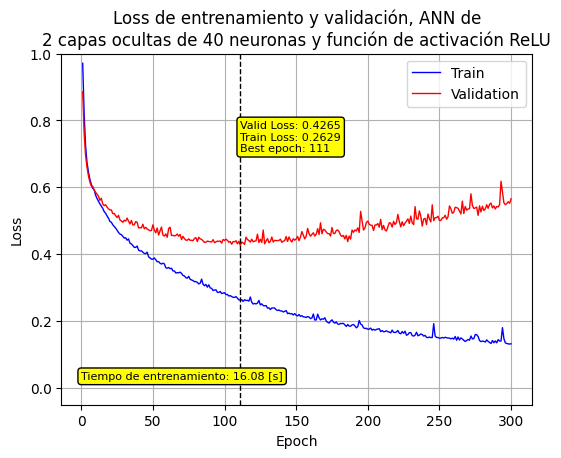

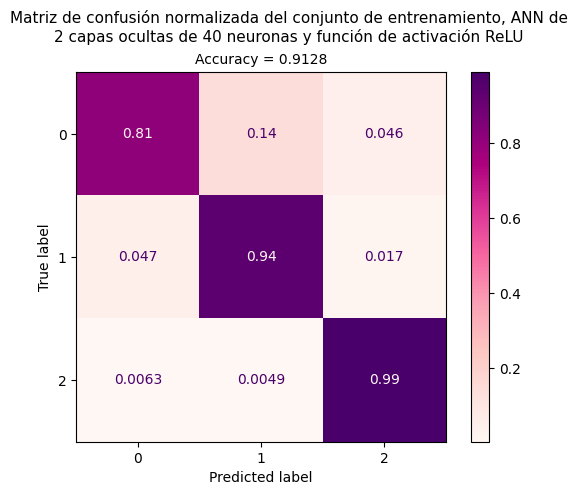

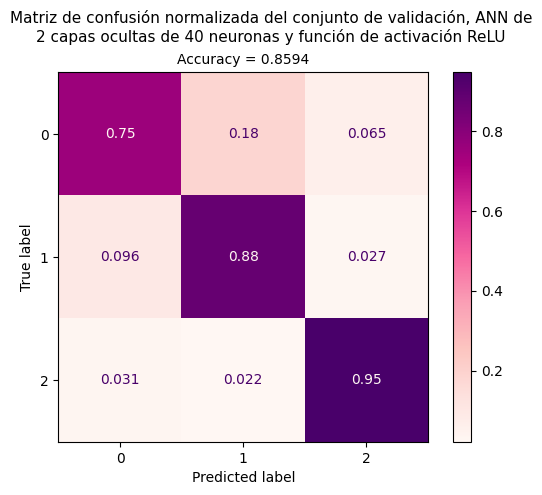


Entrenando: model_40co3_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 83
Mejor modelo en la época 83 con loss de validación = 0.434284


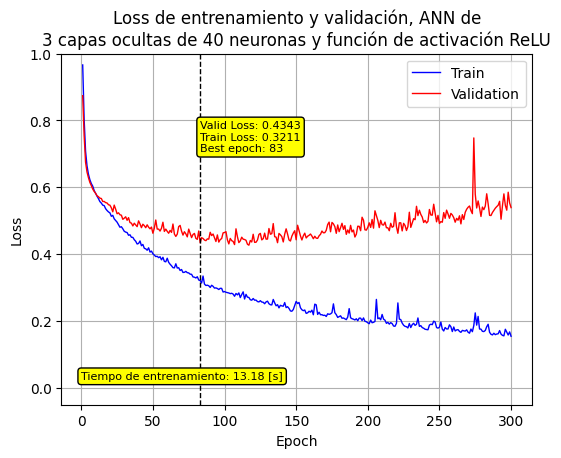

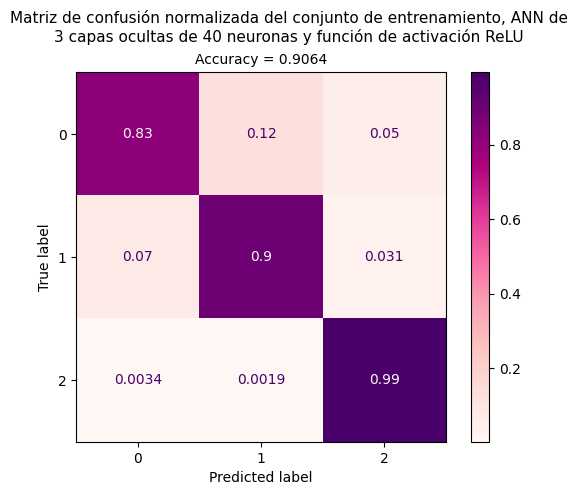

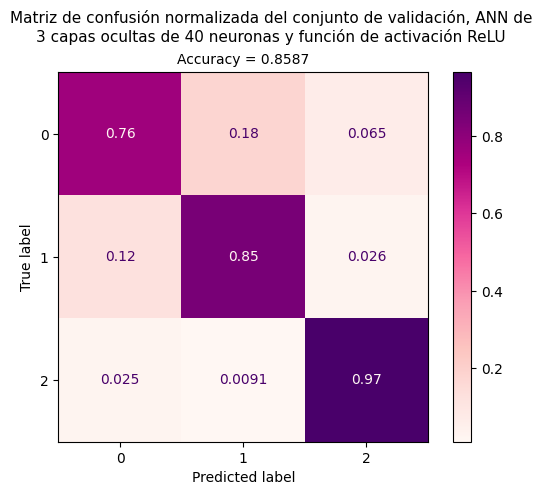


Entrenando: model_40co2_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 130
Mejor modelo en la época 130 con loss de validación = 0.377147


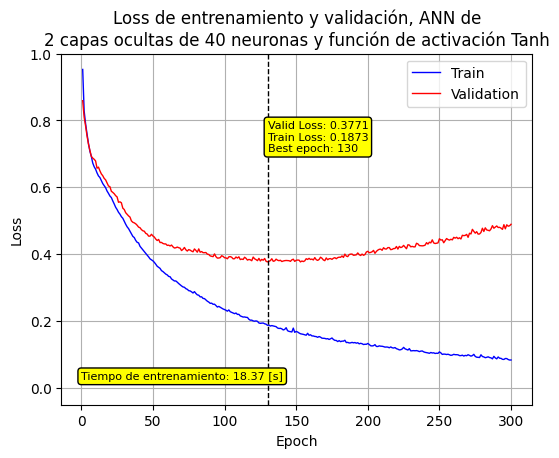

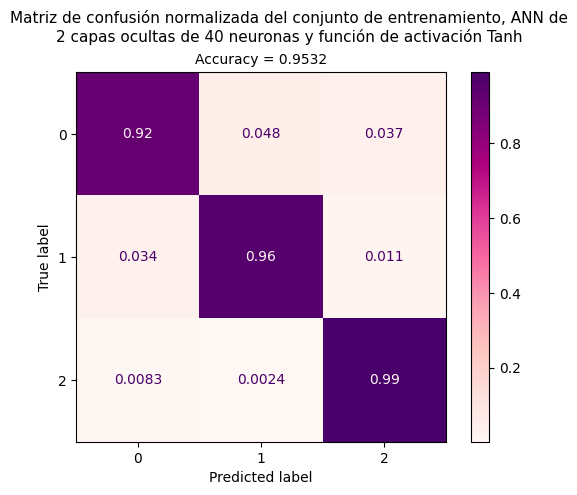

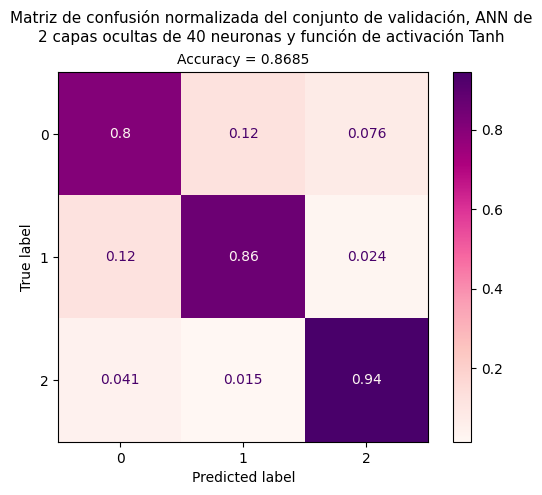


Entrenando: model_40co3_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 124
Mejor modelo en la época 124 con loss de validación = 0.428093


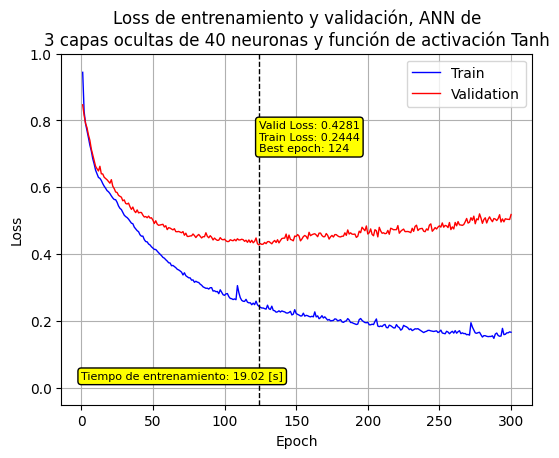

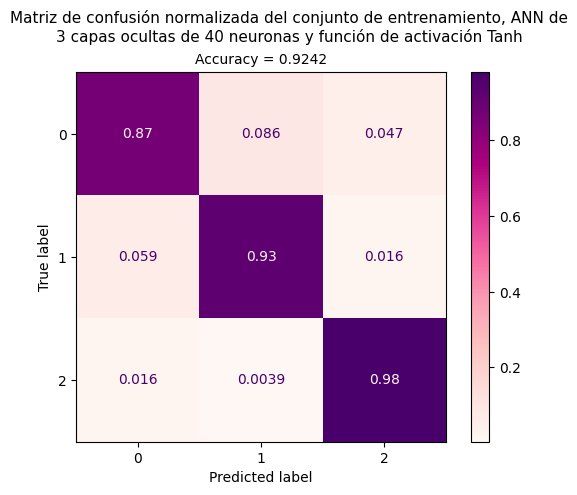

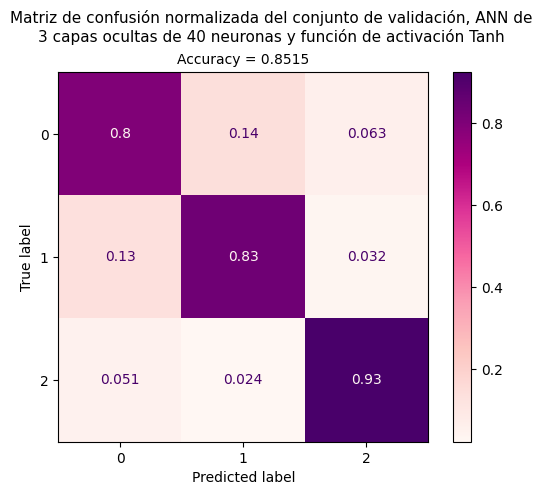


Entrenando: model_90co2_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 94
Mejor modelo en la época 94 con loss de validación = 0.379052


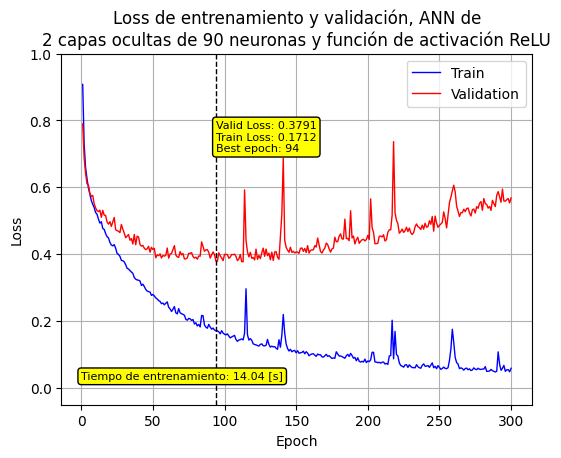

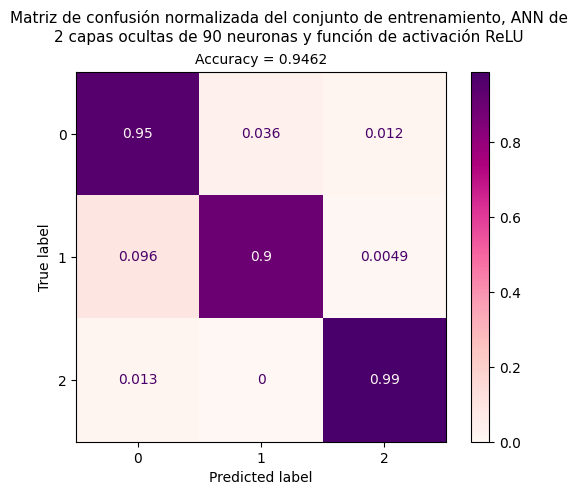

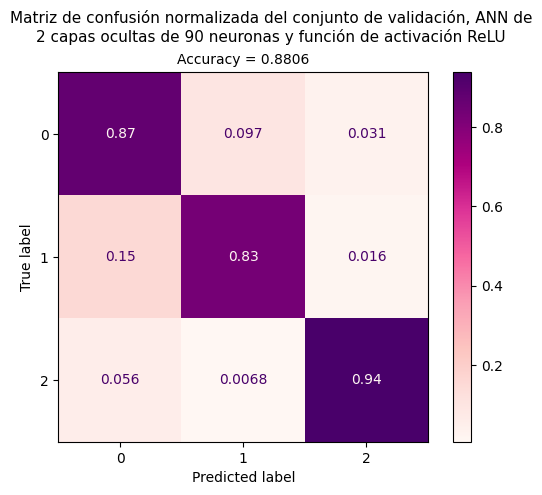


Entrenando: model_90co3_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 45
Mejor modelo en la época 45 con loss de validación = 0.372457


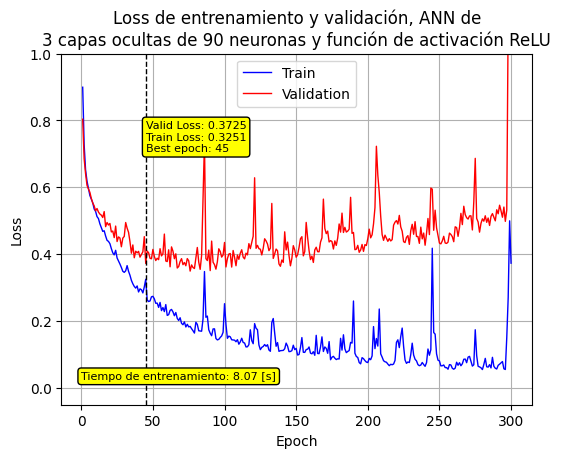

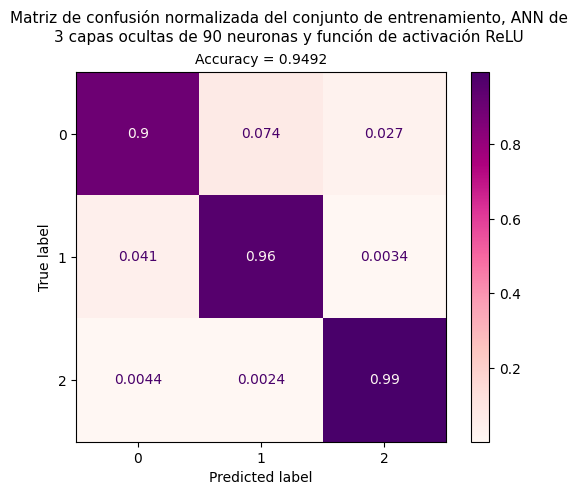

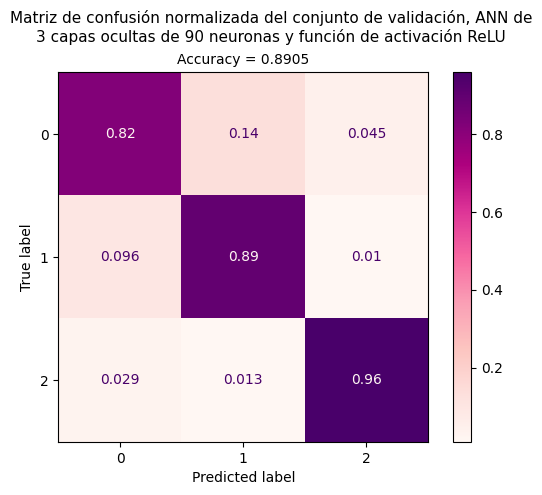


Entrenando: model_90co2_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 79
Mejor modelo en la época 79 con loss de validación = 0.300675


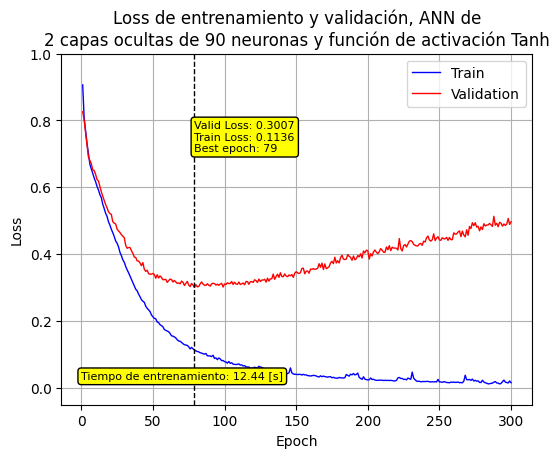

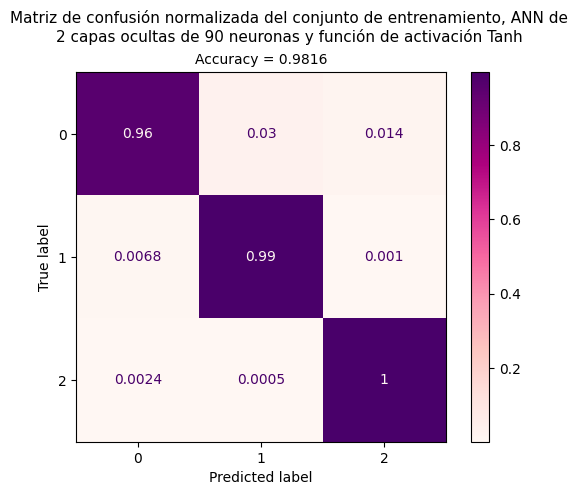

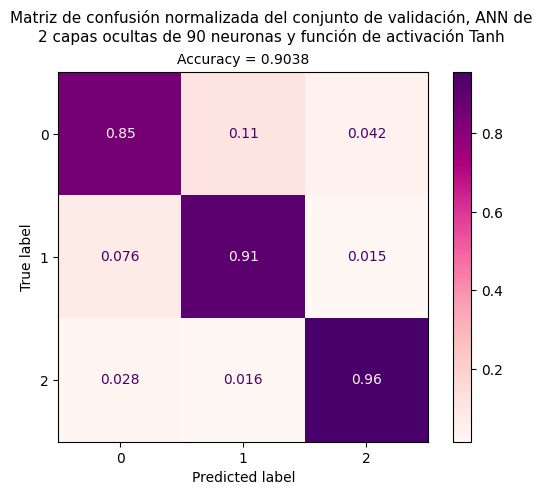


Entrenando: model_90co3_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 74
Mejor modelo en la época 74 con loss de validación = 0.333496


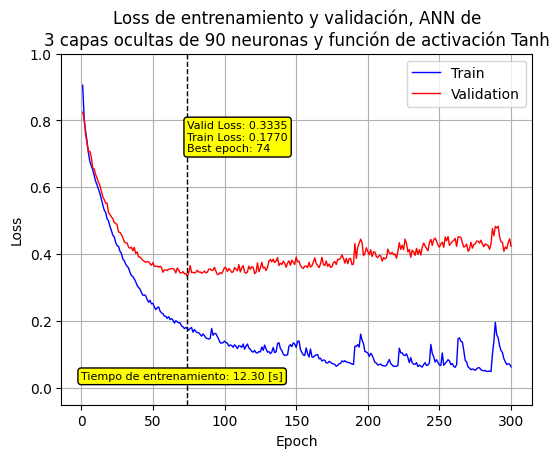

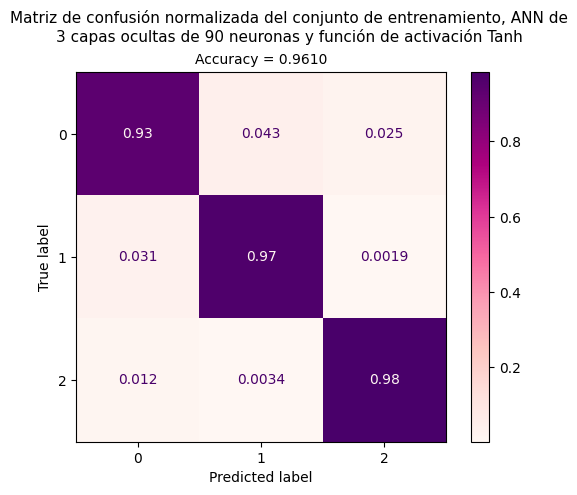

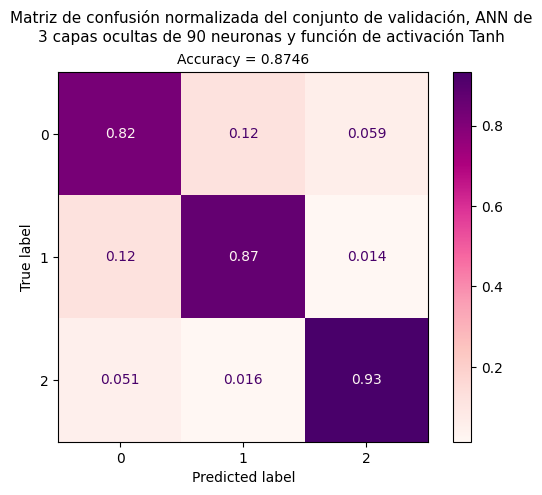


Entrenando: model_140co2_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 83
Mejor modelo en la época 83 con loss de validación = 0.346069


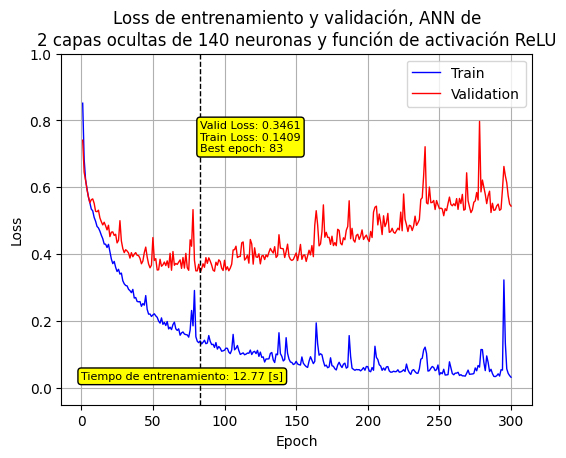

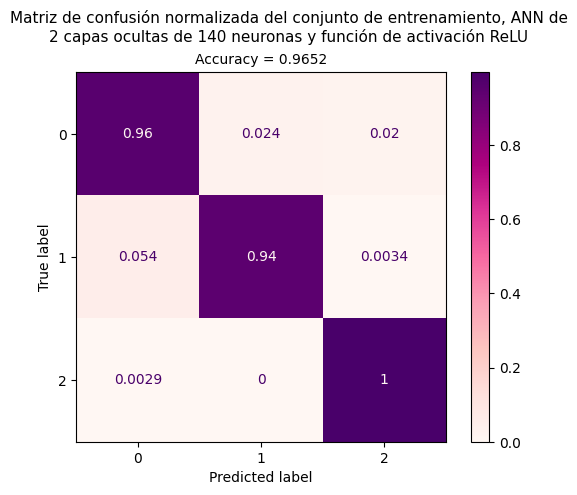

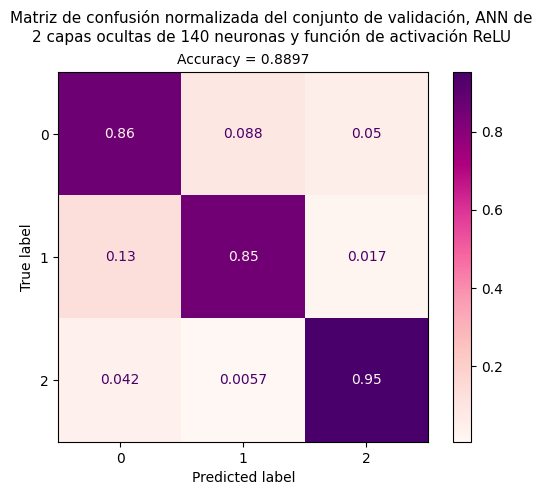


Entrenando: model_140co3_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 47
Mejor modelo en la época 47 con loss de validación = 0.341939


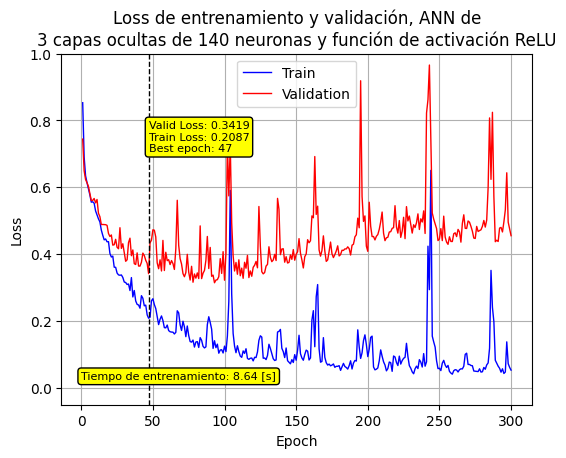

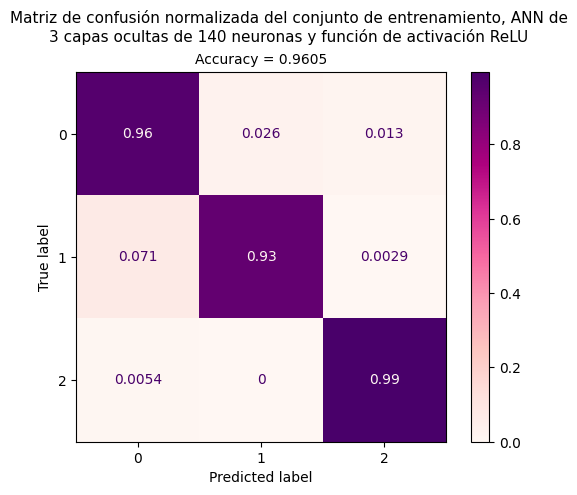

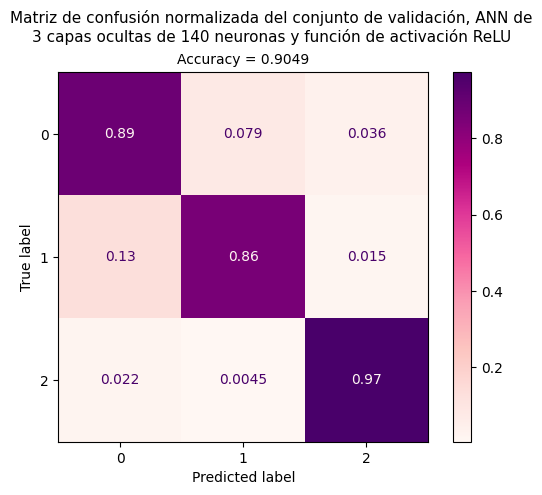


Entrenando: model_140co2_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 76
Mejor modelo en la época 76 con loss de validación = 0.264147


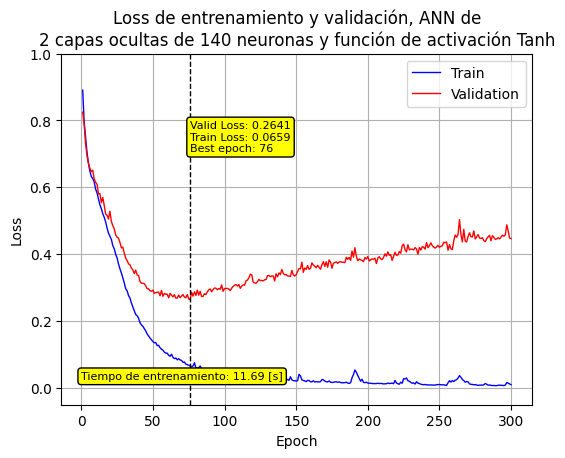

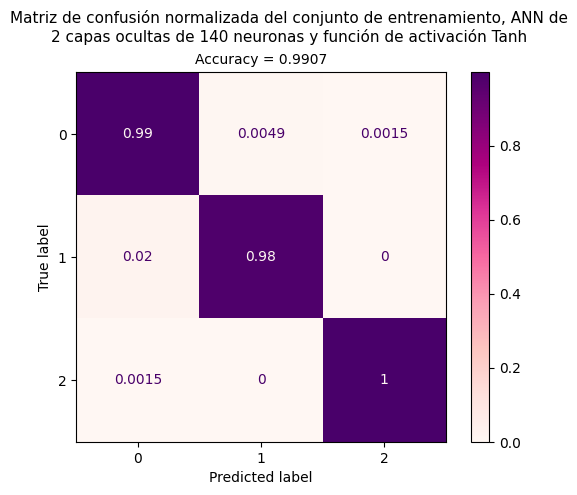

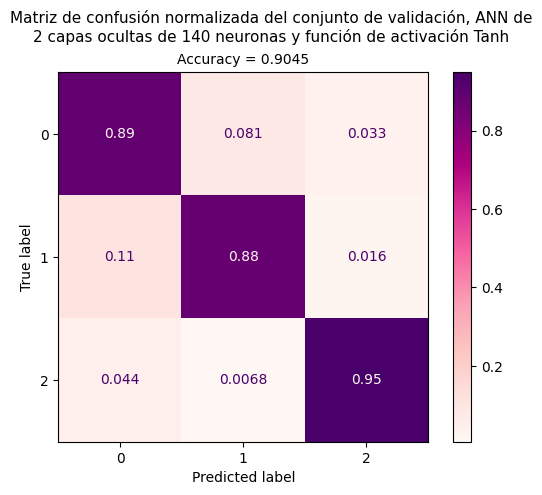


Entrenando: model_140co3_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 87
Mejor modelo en la época 87 con loss de validación = 0.265022


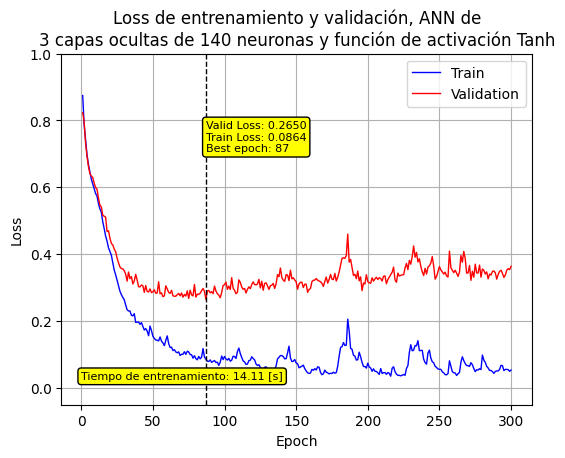

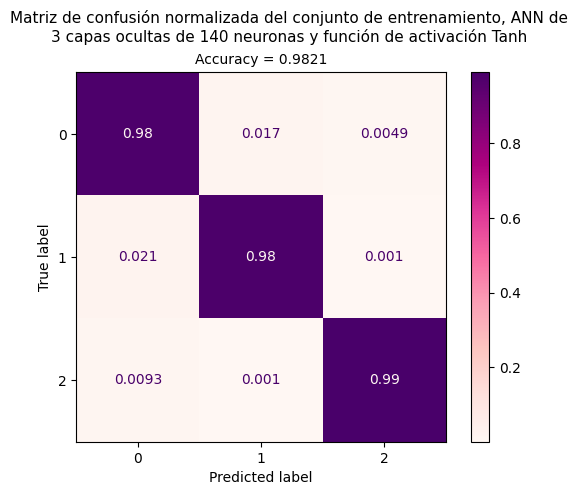

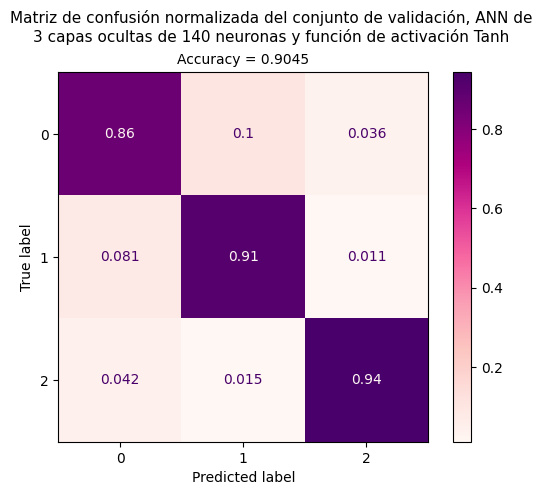


Entrenando: model_200co2_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 36
Mejor modelo en la época 36 con loss de validación = 0.364539


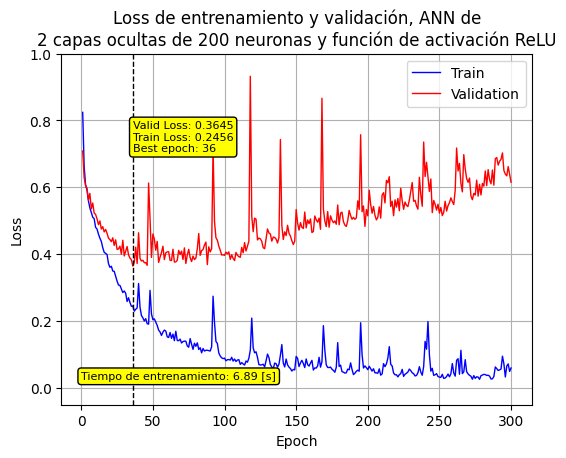

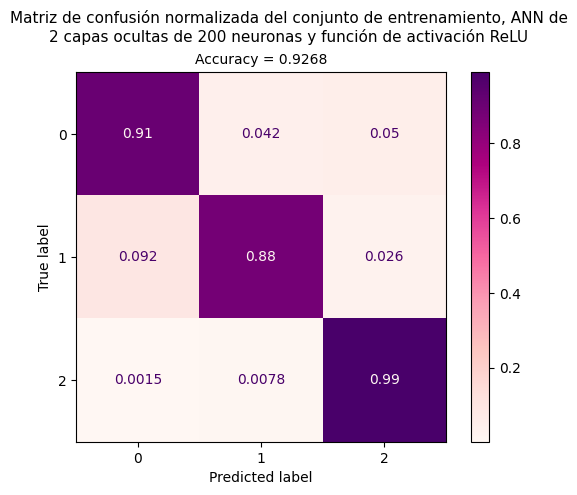

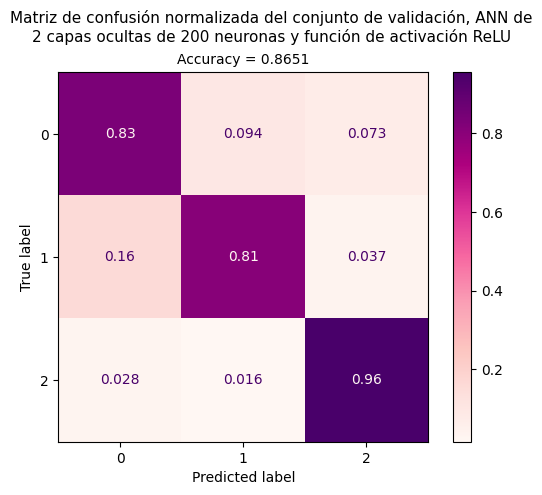


Entrenando: model_200co3_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 53
Mejor modelo en la época 53 con loss de validación = 0.303177


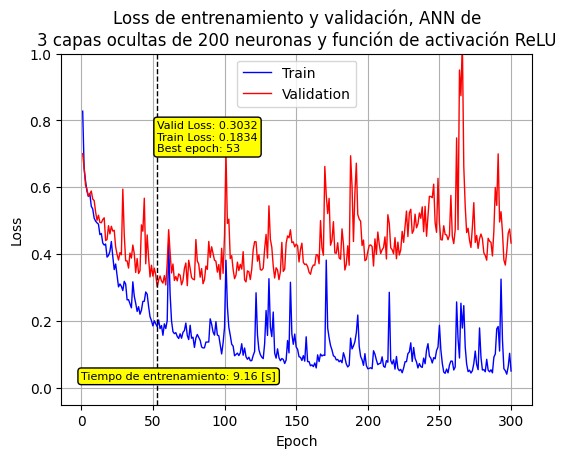

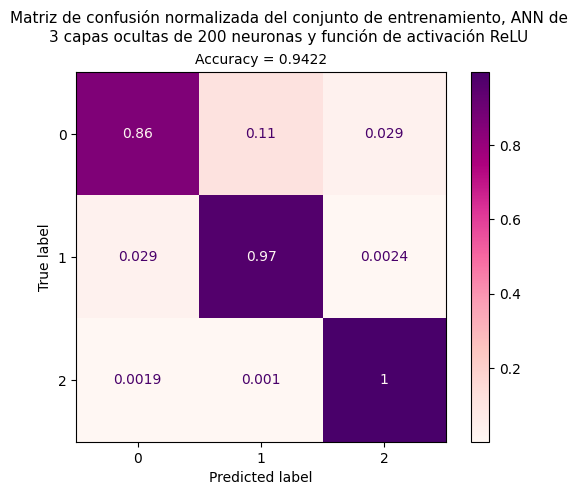

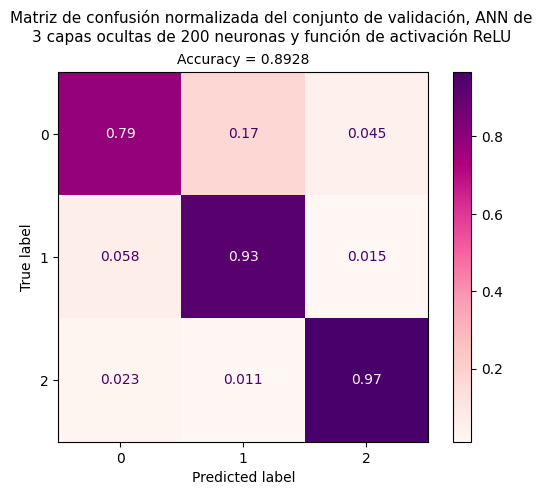


Entrenando: model_200co2_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 54
Mejor modelo en la época 54 con loss de validación = 0.263027


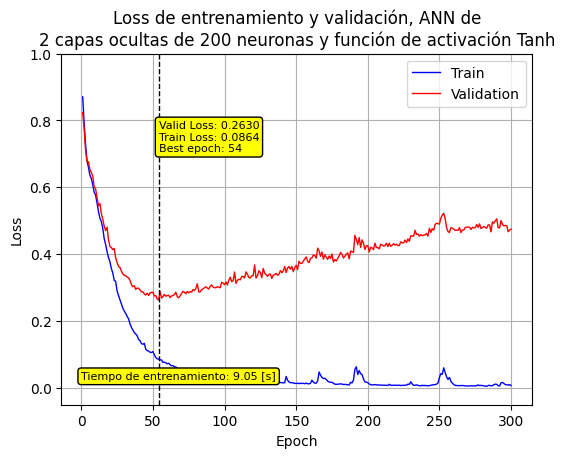

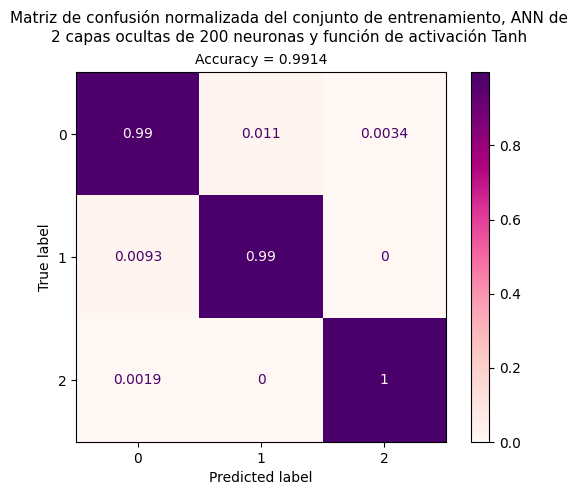

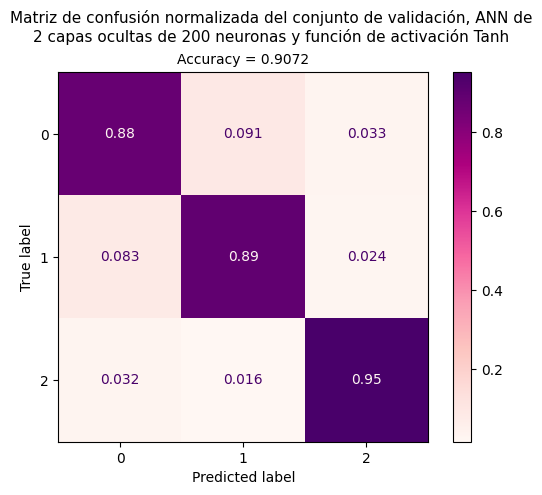


Entrenando: model_200co3_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 68
Mejor modelo en la época 68 con loss de validación = 0.220636


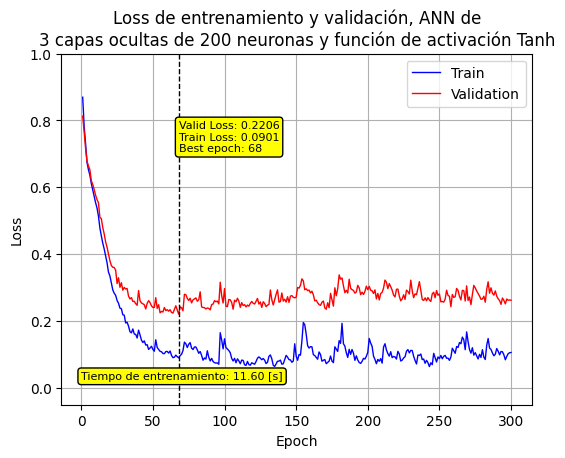

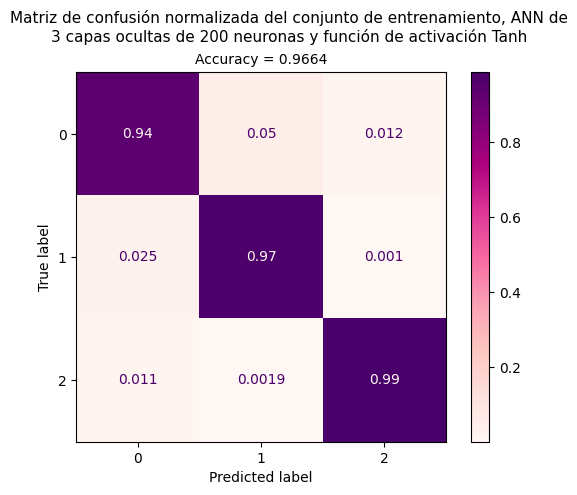

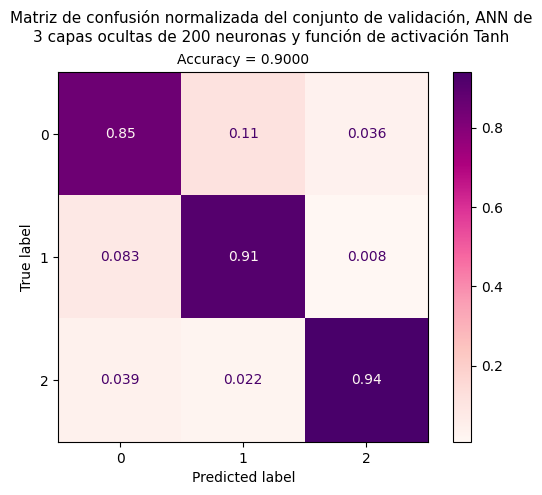


Entrenando: model_300co2_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 61
Mejor modelo en la época 61 con loss de validación = 0.338053


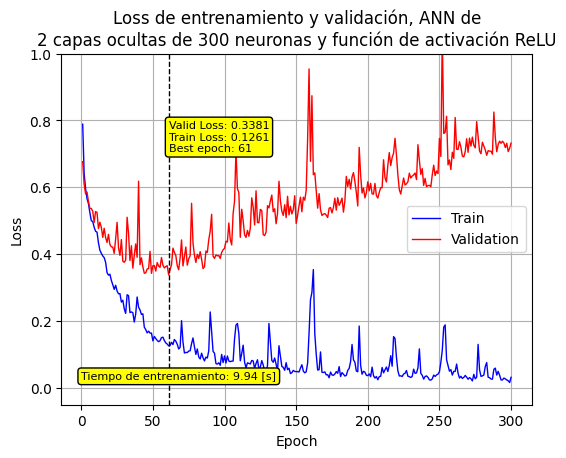

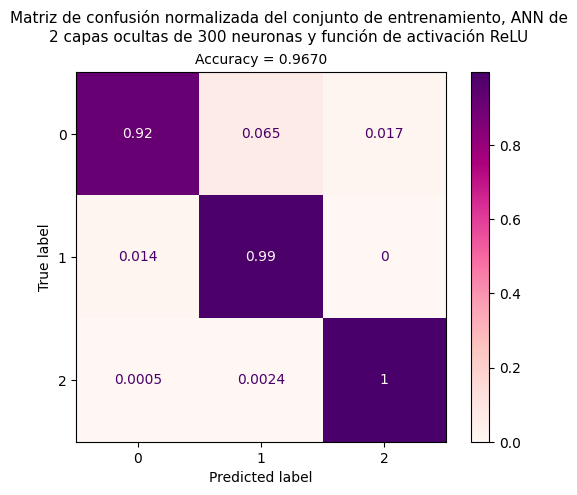

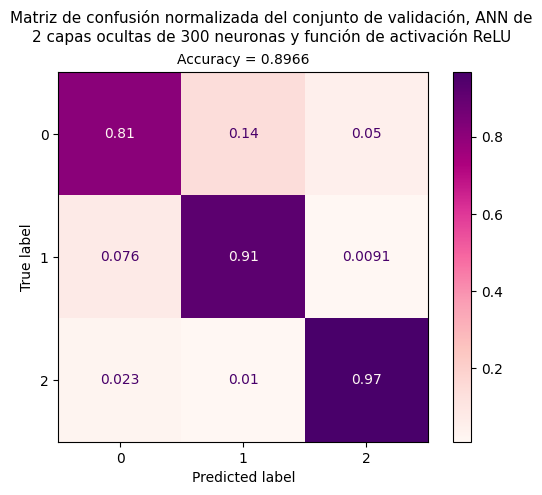


Entrenando: model_300co3_ReLU con LR=0.001
Early stopping at --------------------------------------------------> 51
Mejor modelo en la época 51 con loss de validación = 0.315416


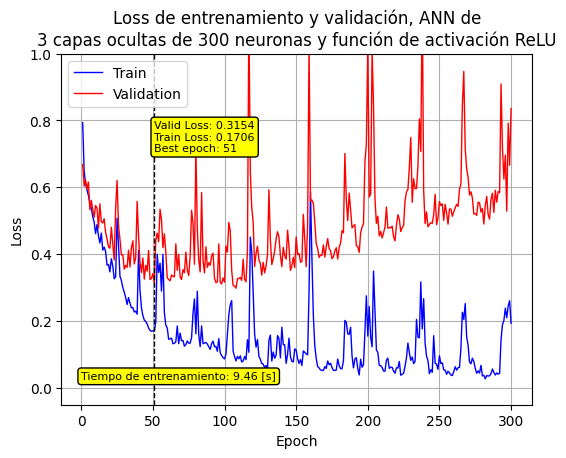

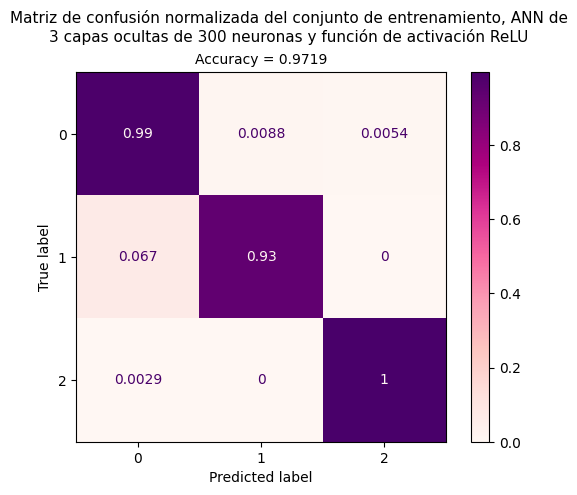

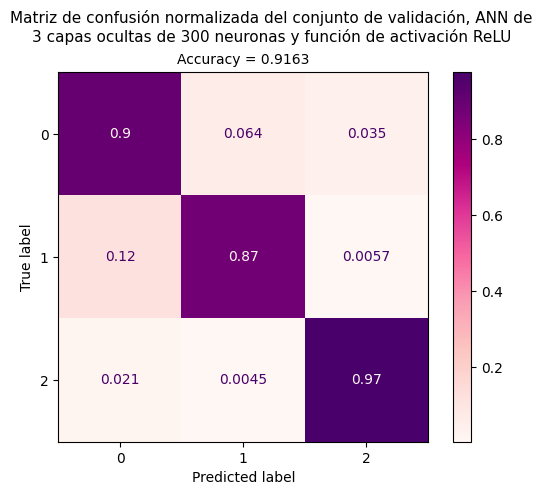


Entrenando: model_300co2_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 53
Mejor modelo en la época 53 con loss de validación = 0.247544


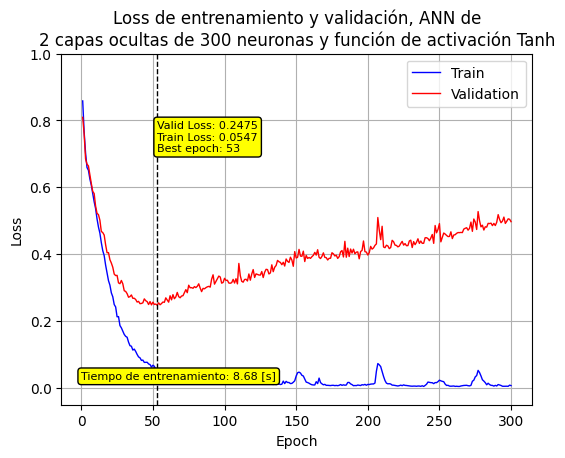

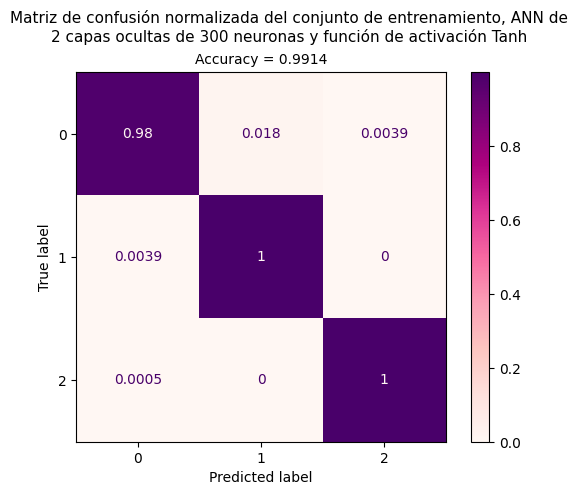

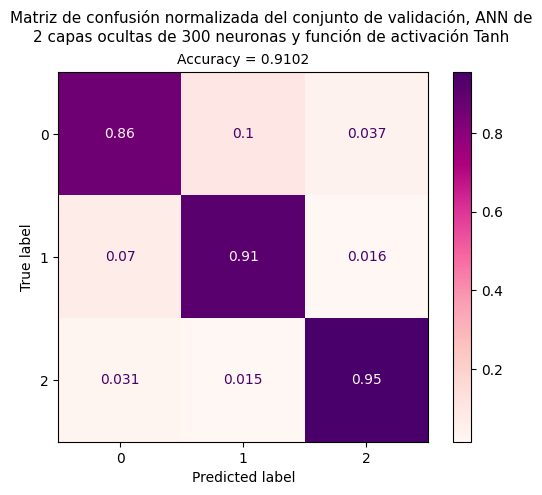


Entrenando: model_300co3_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 44
Mejor modelo en la época 44 con loss de validación = 0.215598


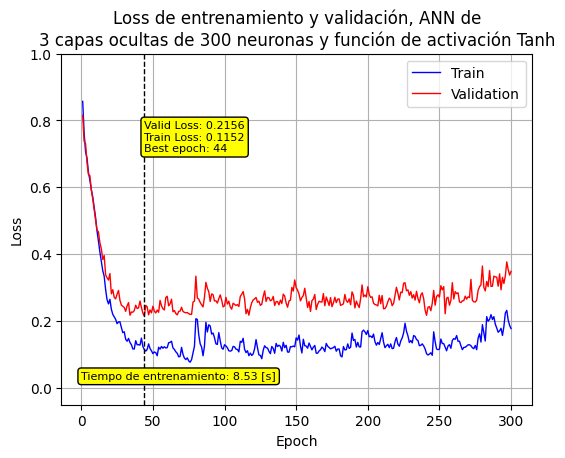

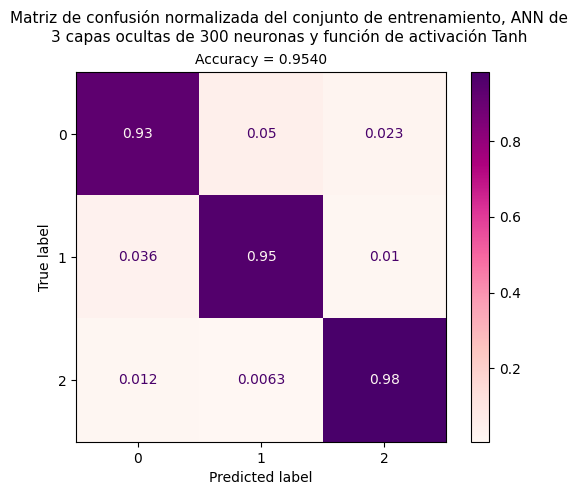

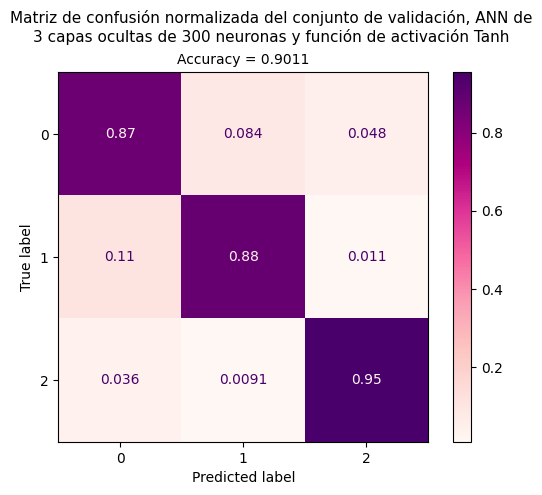

Tiempo de ejecución: 13.77 [min]


name                                  activation  layers  \
1   model_300co3_ReLU  <class 'torch.nn.modules.activation.ReLU'>       3   
2   model_300co2_Tanh  <class 'torch.nn.modules.activation.Tanh'>       2   
3   model_200co2_Tanh  <class 'torch.nn.modules.activation.Tanh'>       2   
4   model_140co3_ReLU  <class 'torch.nn.modules.activation.ReLU'>       3   
5   model_140co3_Tanh  <class 'torch.nn.modules.activation.Tanh'>       3   
6   model_140co2_Tanh  <class 'torch.nn.modules.activation.Tanh'>       2   
7    model_90co2_Tanh  <class 'torch.nn.modules.activation.Tanh'>       2   
8   model_300co3_Tanh  <class 'torch.nn.modules.activation.Tanh'>       3   
9   model_200co3_Tanh  <class 'torch.nn.modules.activation.Tanh'>       3   
10  model_300co2_ReLU  <class 'torch.nn.modules.activation.ReLU'>       2   
11  model_200co3_ReLU  <class 'torch.nn.modules.activation.ReLU'>       3   
12   model_90co3_ReLU  <class 'torch.nn.modules.activation.ReLU'>       3   
13  model_140co2_ReLU  <class 'torch.nn.modules.activation.ReLU'>       2   
14   model_90co2_ReLU  <class 'torch.nn.modules.activation.ReLU'>       2   
15   model_90co3_Tanh  <class 'torch.nn.modules.activation.Tanh'>       3   
16   model_40co2_Tanh  <class 'torch.nn.modules.activation.Tanh'>       2   
17  model_200co2_ReLU  <class 'torch.nn.modules.activation.ReLU'>       2   
18   model_40co2_ReLU  <class 'torch.nn.modules.activation.ReLU'>       2   
19   model_40co3_ReLU  <class 'torch.nn.modules.activation.ReLU'>       3   
20   model_40co3_Tanh  <class 'torch.nn.modules.activation.Tanh'>       3   

    hidden_size     lr  valid_loss  train_loss  best_epoch       time  \
1           300  0.001    0.315416    0.170612          51   9.457508   
2           300  0.001    0.247544    0.054671          53   8.676911   
3           200  0.001    0.263027    0.086449          54   9.054511   
4           140  0.001    0.341939    0.208704          47   8.643709   
5           140  0.001    0.265022    0.086375          87  14.108104   
6           140  0.001    0.264147    0.065878          76  11.691121   
7            90  0.001    0.300675    0.113578          79  12.440025   
8           300  0.001    0.215598    0.115203          44   8.525418   
9           200  0.001    0.220636    0.090079          68  11.600600   
10          300  0.001    0.338053    0.126142          61   9.935038   
11          200  0.001    0.303177    0.183387          53   9.157960   
12           90  0.001    0.372457    0.325123          45   8.072070   
13          140  0.001    0.346069    0.140949          83  12.768258   
14           90  0.001    0.379052    0.171194          94  14.041158   
15           90  0.001    0.333496    0.177028          74  12.301995   
16           40  0.001    0.377147    0.187330         130  18.366116   
17          200  0.001    0.364539    0.245578          36   6.885713   
18           40  0.001    0.426512    0.262940         111  16.084358   
19           40  0.001    0.434284    0.321147          83  13.181184   
20           40  0.001    0.428093    0.244364         124  19.023766   

     acc_val  
1   0.916256  
2   0.910193  
3   0.907162  
4   0.904888  
5   0.904509  
6   0.904509  
7   0.903751  
8   0.901099  
9   0.899962  
10  0.896552  
11  0.892762  
12  0.890489  
13  0.889731  
14  0.880637  
15  0.874574  
16  0.868511  
17  0.865100  
18  0.859416  
19  0.858659  
20  0.851459

In [24]:
# Hiperparámetros
hidden_sizes = [40, 90, 140, 200, 300]
# hidden_sizes = [200, 300, 400]
# hidden_sizes = [300]

activations = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh}
# activations = {'Tanh': nn.Tanh}

num_hidden_layers = [2, 3]
# num_hidden_layers = [3]

learning_rates = [1e-3]

n_epochs = 300

patience = 15

ruta = '/content/ANN/graficos/GS/' # Ruta para guardar los gráficos, variable global en este punto
os.makedirs(ruta, exist_ok=True)

t0 = time.time()/60
search_results = GS_ANN(hidden_sizes, activations, num_hidden_layers, learning_rates, n_epochs, patience, dataloader_train_GS, dataloader_val_GS)
tf = time.time()/60
print(f'Tiempo de ejecución: {tf - t0:.2f} [min]')

display(search_results)

# Entrenamiento de la mejor red con el conjunto completo de características

Early stopping at --------------------------------------------------> 43
Mejor modelo en la época 43 con loss de validación = 0.314773


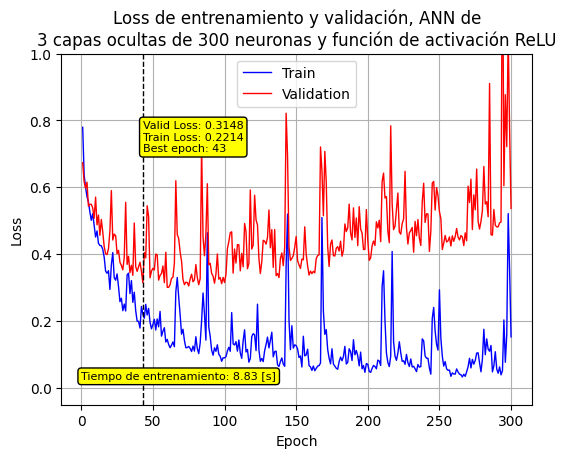

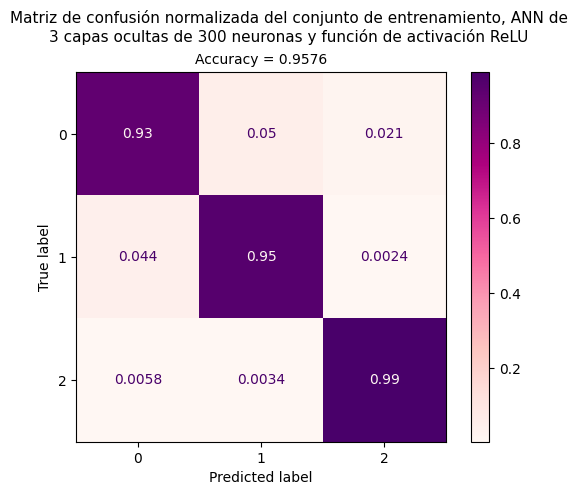

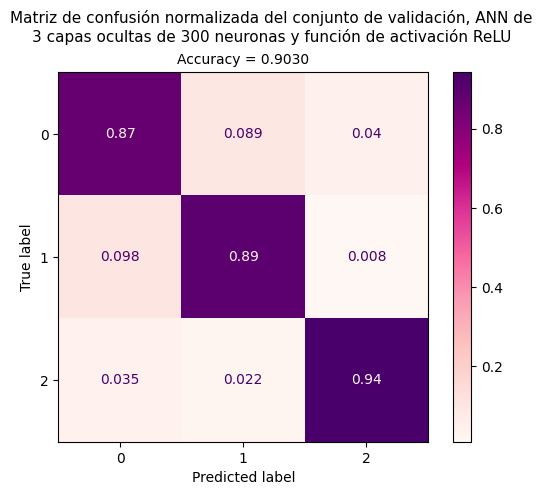

In [28]:
ruta = '/content/ANN/graficos/train/' # Ruta para guardar los gráficos, variable global en este punto

# La mejor red encontrad mediante el Grid Search
model_validated, optimizer = ANN_by_name(search_results)

model_validated = model_validated.to(device)

patience=15; n_epochs=300

# model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val = train_model_generic(model_validated, patience=patience, n_epochs=n_epochs, optimizer=optimizer, dataloader_tr=dataloader_train, dataloader_vl=dataloader_val)
model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val = train_model_generic(model_validated, patience, n_epochs, optimizer, dataloader_train, dataloader_val)
acc_trained_model = results_ANN(model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val)

# Clasificación con un conjunto reducido de características

## Selección mediante wrapper strategy

In [ ]:
# Asegúrate de que el SVC sea lineal
svc = svm.SVC(kernel='linear', C=10)
svc.fit(df_train, y_train)

# selector = SelectFromModel(estimator=svc, prefit=True, max_features=54, importance_getter='coef_') #Investigar que es prefit
selector = SelectFromModel(estimator=svc, max_features=54, threshold=-np.inf)

best_indx_wrapper = np.where(selector.get_support())[0]
best_feat_wrapper = [df_train.keys()[i] for i in np.where(selector.get_support())[0]] #Toma los indices de aquellas características que fueron seleccionadas como importantes con el método y luego busca el nombre de la característica correspodiente en la lista original de nombres definida al inicio del código

print('Mejores características:',best_feat_wrapper)
# Se define el nuevo conjunto de entrenamiento y validación tomando las características más importantes encontradas con este método
df_train_wrapper = df_train[best_feat_wrapper]
df_val_wrapper = df_val[best_feat_wrapper]
df_test_wrapper = df_test[best_feat_wrapper]

dataloader_train_wrapper, dataloader_val_wrapper, dataloader_test_wrapper = dataloader_creator(df_train_wrapper, y_train, df_val_wrapper, y_val, df_test_wrapper)


Mejores características: ['mean_R1', 'var_R1', 'max_R1', 'sma_R1', 'enrgy_R1', 'iqr_R1', 'entpy_R1', 'mean_R2', 'var_R2', 'mad_R2', 'ran_R2', 'sma_R2', 'enrgy_R2', 'iqr_R2', 'entpy_R2', 'mean_R3', 'var_R3', 'max_R3', 'min_R3', 'sma_R3', 'enrgy_R3', 'entpy_R3', 'mean_R4', 'var_R4', 'max_R4', 'min_R4', 'ran_R4', 'sma_R4', 'enrgy_R4', 'iqr_R4', 'enrgy_R5', 'mean_R6', 'var_R6', 'mad_R6', 'max_R6', 'min_R6', 'ran_R6', 'sma_R6', 'enrgy_R6', 'entpy_R6', 'mean_R7', 'var_R7', 'mad_R7', 'max_R7', 'min_R7', 'ran_R7', 'sma_R7', 'enrgy_R7', 'iqr_R7', 'var_R8', 'enrgy_R8', 'max_Humidity', 'min_Humidity', 'enrgy_Humidity']


In [ ]:
dataloader_train_wrapper, dataloader_val_wrapper, dataloader_test_wrapper = dataloader_creator(df_train_wrapper, y_train, df_val_wrapper, y_val, df_test_wrapper)
dataloader_train_wrapper_GS, dataloader_val_wrapper_GS = dataloader_creator_GS(df_val_wrapper, y_val)


Entrenando: model_300co3_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 46
Mejor modelo en la época 46 con loss de validación = 0.225283


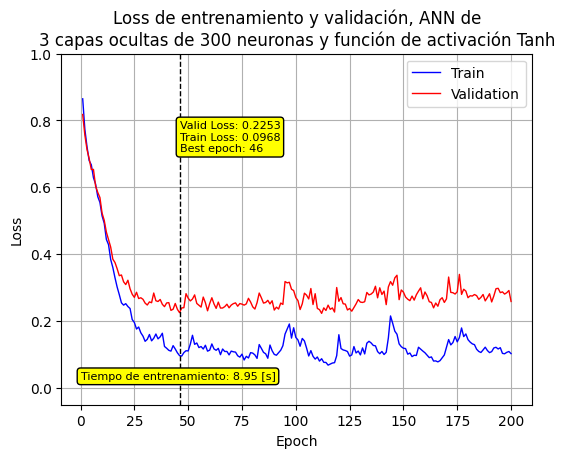

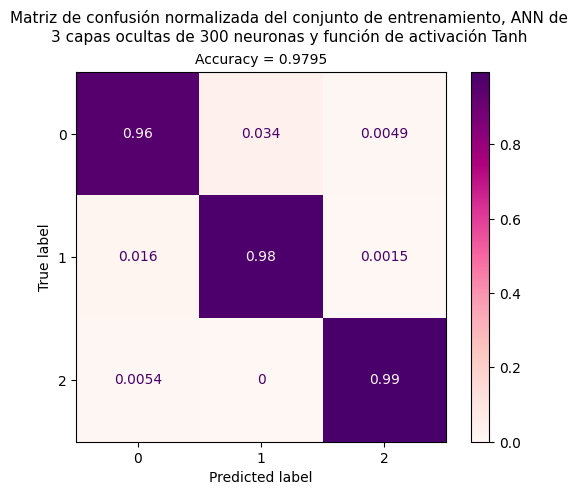

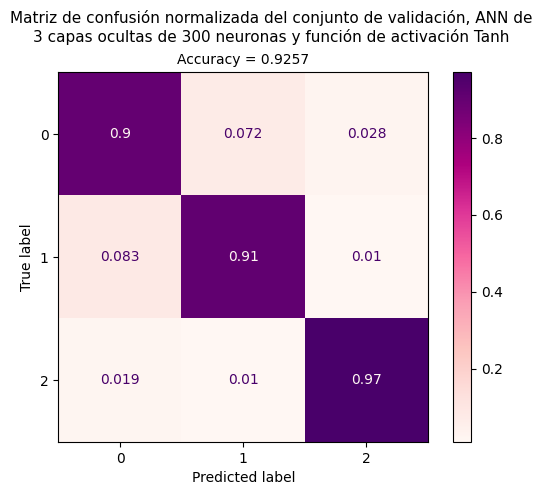

Early stopping at --------------------------------------------------> 37
Mejor modelo en la época 37 con loss de validación = 0.222788


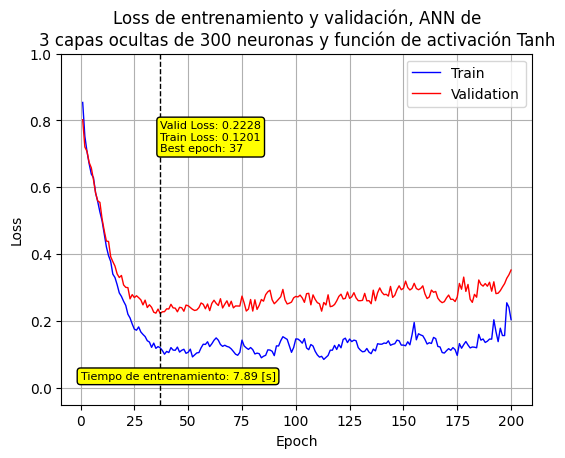

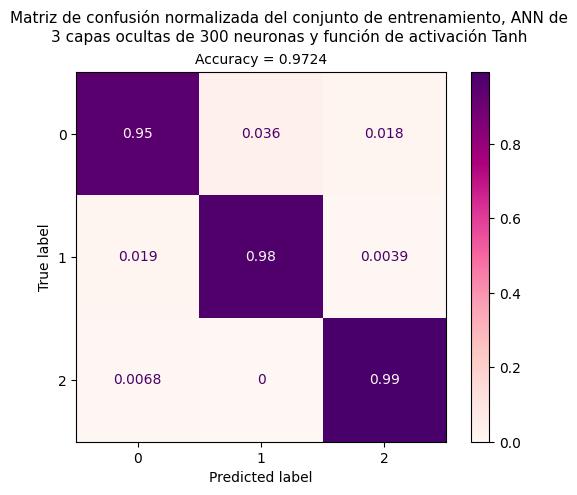

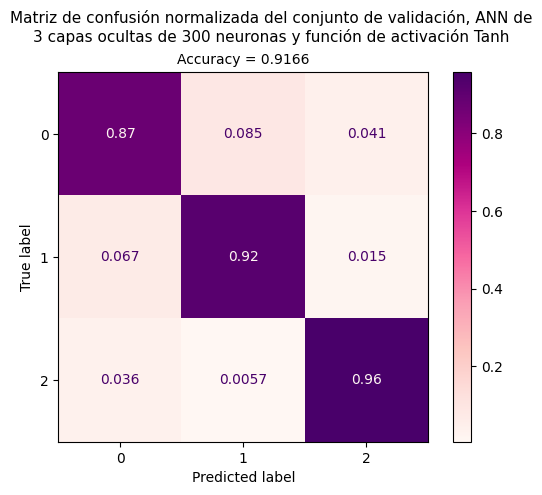

In [ ]:
ruta = '/content/ANN/graficos/train/feature_selec/wrapper/' # Ruta para guardar los gráficos, variable global en este punto

# hidden_sizes = [200, 300, 400]
hidden_sizes = [300]

# activations = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh}
activations = {'Tanh': nn.Tanh}

# num_hidden_layers = [2, 3]
num_hidden_layers = [3]

learning_rates = [1e-3]

n_epochs = 200

patience = 15

gs_ann_wrapper = GS_ANN(hidden_sizes, activations, num_hidden_layers, learning_rates, n_epochs, patience, dataloader_train_wrapper_GS, dataloader_val_wrapper_GS)
model_validated_wrapper, optimizer_wrapper = ANN_by_name(gs_ann_wrapper)

model_validated_wrapper = model_validated_wrapper.to(device)

model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val = train_model_generic(model_validated_wrapper, patience, n_epochs, optimizer_wrapper, dataloader_train_wrapper, dataloader_val_wrapper)
acc_trained_model = results_ANN(model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val)

## Selección empírica de características

In [ ]:
dataloader_train_w_mean, dataloader_val_w_mean, dataloader_test_w_mean = dataloader_creator(df_train[[col for col in df_train.columns if col.startswith('mean_')]], y_train, df_val[[col for col in df_val.columns if col.startswith('mean_')]], y_val, df_test)
dataloader_train_w_mean_GS, dataloader_val_w_mean_GS = dataloader_creator_GS(df_val[[col for col in df_val_GS.columns if col.startswith('mean_')]], y_val)


Entrenando: model_300co2_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 60
Mejor modelo en la época 60 con loss de validación = 0.237722


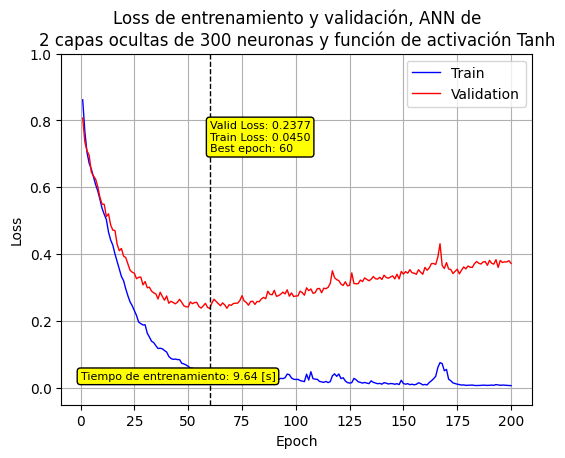

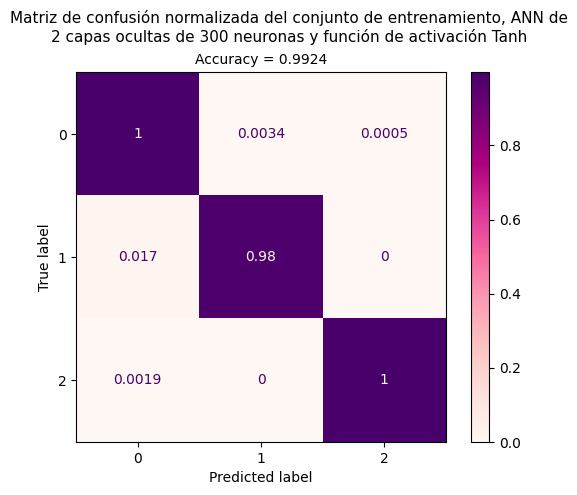

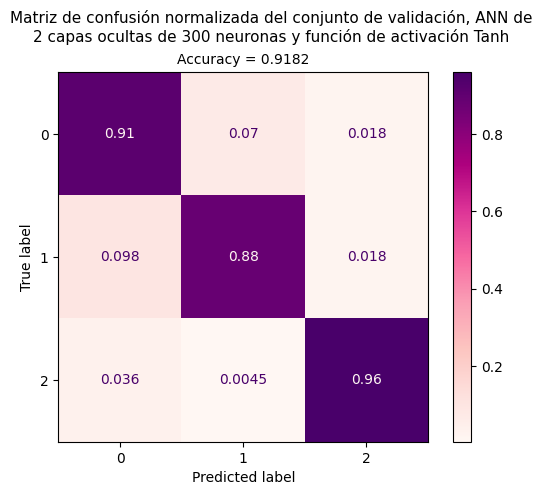


Entrenando: model_300co3_Tanh con LR=0.001
Early stopping at --------------------------------------------------> 40
Mejor modelo en la época 40 con loss de validación = 0.225194


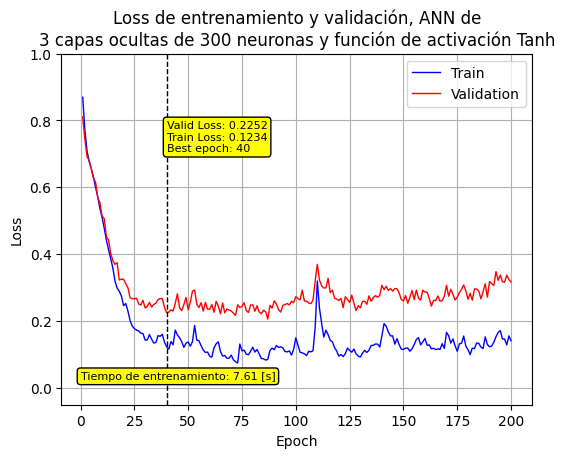

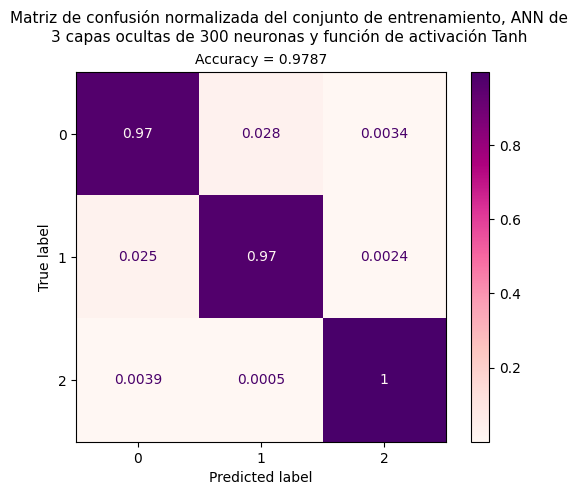

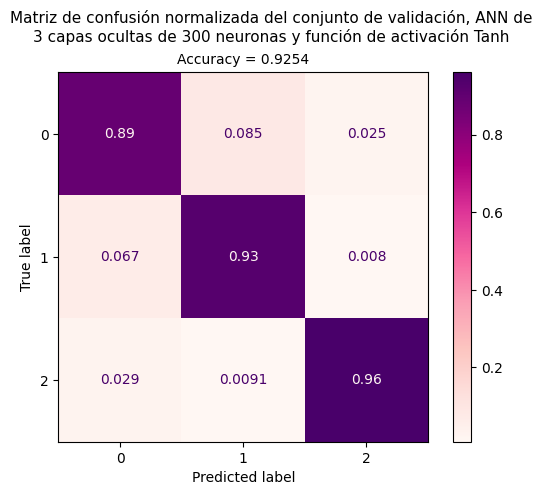

Early stopping at --------------------------------------------------> 49
Mejor modelo en la época 49 con loss de validación = 0.222209


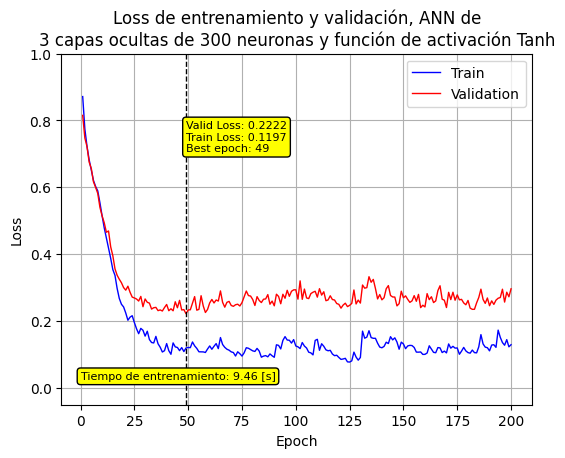

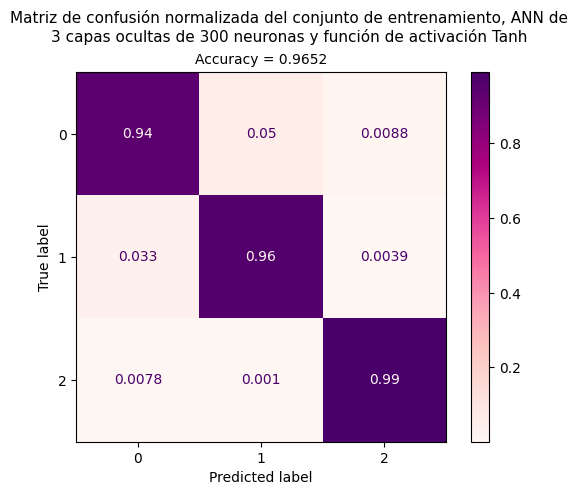

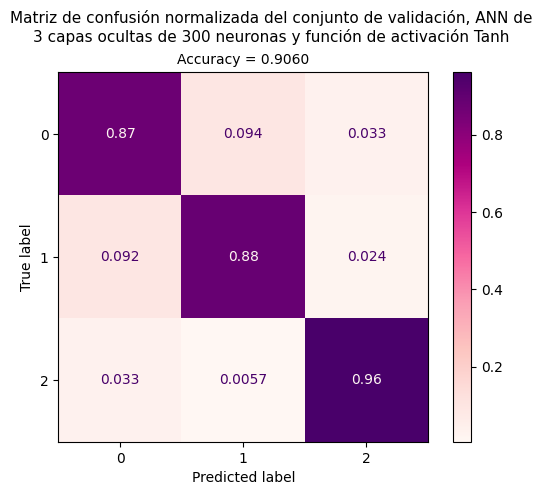

In [ ]:
ruta = '/content/ANN/graficos/train/feature_selec/empiric/' # Ruta para guardar los gráficos, variable global en este punto

# hidden_sizes = [40, 90, 140, 200, 300]
# hidden_sizes = [200, 300, 400]
hidden_sizes = [300]

# activations = {'ReLU': nn.ReLU, 'Tanh': nn.Tanh}
activations = {'Tanh': nn.Tanh}

num_hidden_layers = [2, 3]
# num_hidden_layers = [3]

learning_rates = [1e-3]

n_epochs = 200

patience = 15

gs_ann_w_mean = GS_ANN(hidden_sizes, activations, num_hidden_layers, learning_rates, n_epochs, patience, dataloader_train_w_mean_GS, dataloader_val_w_mean_GS)
model_validated_w_mean, optimizer_w_mean = ANN_by_name(gs_ann_wrapper)

model_validated_w_mean = model_validated_w_mean.to(device)

model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val = train_model_generic(model_validated_w_mean, patience, n_epochs, optimizer_w_mean, dataloader_train_w_mean, dataloader_val_w_mean)
acc_trained_model = results_ANN(model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val)

# Borrador

Early stopping at --------------------------------------------------> 32
Mejor modelo en la época 32 con loss de validación = 0.239543


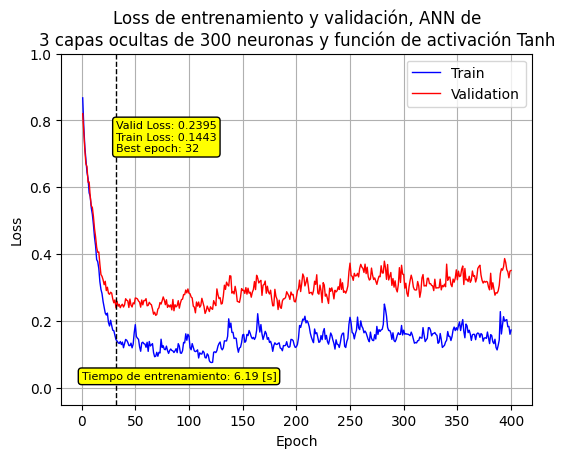

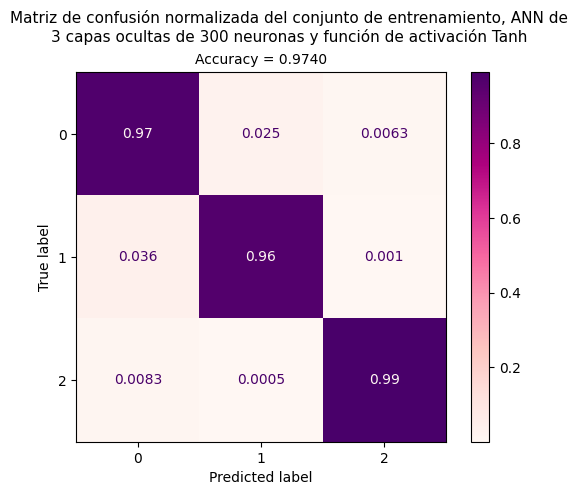

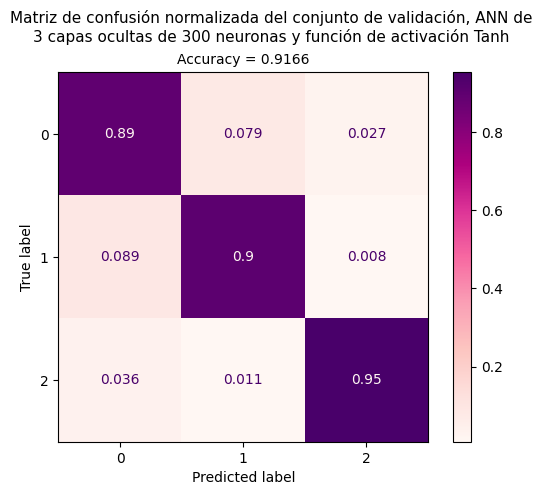

In [ ]:
ruta = '/content/ANN/graficos/train/feature_selec/empiric/' # Ruta para guardar los gráficos, variable global en este punto

model_name = df_res.iloc[0,0]

h = df_res.iloc[0,3]
n = df_res.iloc[0,2]
activ_funct = df_res.iloc[0,1]

# La mejor red encontrad amediante el Grid Search
model_validated = nn.Sequential(nn.Linear(108, h_layers))
for _ in range(n - 1):
    model_validated.append(nn.Linear(h, h))
model_validated.append(activ_funct())
model_validated.append(nn.Linear(h, 3))
model_validated.name = model_name  # Se agrega el nombre como atributo

model_validated = model_validated.to(device)
optimizer = torch.optim.Adam(model_validated.parameters(), lr=lr)

model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val = train_model_generic(model_validated, patience=15, n_epochs=400, optimizer=optimizer, dataloader_tr=dataloader_train_w_mean, dataloader_vl=dataloader_val_w_mean)
acc_trained_model = results_ANN(model_trained, train_loss, valid_loss, t_time, best_ep, data_load_tr, data_load_val)